# Bureau Log Feature Engineering

## Setup

### Imports

In [1]:
# import packages

import os
import time
import warnings
import zipfile
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

### Custom Classes

In [2]:
# transformer reduces the list of columns by a subset
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# transformer produces a reduced column list by collinearity reduction
class CollinearityReducer(BaseEstimator, TransformerMixin):
    
    '''
    This class reduces features by measuring collinearity between the input variables and target.
    Works on numerical features based on the correlations between each variable pair.
    Of the var1iable pairs with absolute correlations above the threshold value...
    ...the variables with the lowest target variable correlation are dropped from the input X.
    The process is repeated until there are no more colinear pairs with absolute correlations above the threshold.
    ...Or max_iter. 
    
    The transformation returns a subset of feature names... 
    ...to be used with the DataFrameSelector() Class. 

    This class is meant to be run at the end of the numerical pipeline
    PRIOR TO THE ACTUAL PIPELINE - only returns subset for DataFrameSelector().

    NOTE! The function receives a dataframe structured with the target variable in first column.
    '''
    
    def __init__(self, attribute_names, threshold=0.5, max_iter=None):
        self.attribute_names = attribute_names
        self.threshold = threshold
        self.max_iter = max_iter
            
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None): 
        
        dataframe = pd.concat([y, pd.DataFrame(X)], axis=1)
        
        i = 0
        while i <= self.max_iter:

            # read-in and assign columns
            # gets correlation matrix between variables and pivots to a longer df
            # identify target variable
            # drop same-name and target correlations pairs
              
            df = dataframe
            features = df.iloc[:,1:].columns
            target_name = df.iloc[:,0].name

            df = pd.melt(abs(df.corr()).reset_index(), id_vars='index', value_vars=features)
            targets = df[df['index']==target_name]
            df = df[(df['index'] != df['variable']) & (df['index'] != target_name) & (df['variable'] != target_name)]

            # combine the correlated variables into ordered pairs
            # aggregate the max correlation and sort pairs
            # split out the variables from the pair
            # join the target variable correlations for each variable pair, rename columns

            df['joined'] = df[['index', 'variable']].apply(lambda row: '::'.join(np.sort(row.values.astype(str))), axis=1)

            df = df.groupby('joined', as_index=False) \
                   .agg({'value':'max'}) \
                   .sort_values(by='value', ascending=False)

            df[['var_1','var_2']] = df['joined'].str.split("::",expand=True).astype(int)

            df = df.merge(targets, how='left', left_on='var_1', right_on='variable') \
                   .merge(targets, how='left', left_on='var_2', right_on='variable')
            df.rename(columns = {'value_x':'var_pair_corr', 'value_y':'var_1_target_corr', 'value':'var_2_target_corr'}, inplace = True)

            # This section takes all variable pairs with a correlation greater than threshold
            # tests to determine which variable has a higher correlation with the target.
            # The higher of the two gets marked as a win
            # While the other gets marked as a loss
            # the wins and losses for each variable are then grouped and summed

            exceeds = df[df['var_pair_corr']>self.threshold]

            # break if none above threshold
            if len(exceeds['var_pair_corr'])==0:
                break

            # "correlation competition"
            exceeds['var_1_win'] = exceeds.apply(lambda row: 1 if row["var_1_target_corr"] >= row["var_2_target_corr"] else 0, axis=1)
            exceeds['var_1_loss'] = exceeds.apply(lambda row: 1 if row["var_2_target_corr"] >= row["var_1_target_corr"] else 0, axis=1)
            exceeds['var_2_win'] = exceeds.apply(lambda row: 1 if row["var_1_target_corr"] < row["var_2_target_corr"] else 0, axis=1)
            exceeds['var_2_loss'] = exceeds.apply(lambda row: 1 if row["var_2_target_corr"] < row["var_1_target_corr"] else 0, axis=1)

            # aggregate scores
            var1 = exceeds[['var_1', 'var_1_win', 'var_1_loss']].groupby('var_1', as_index=False) \
                                                                .agg({'var_1_win':'sum', 'var_1_loss':'sum'})
            var1.rename(columns = {'var_1':'var', 'var_1_win':'win', 'var_1_loss':'loss'}, inplace=True)

            var2 = exceeds[['var_2', 'var_2_win', 'var_2_loss']].groupby('var_2', as_index=False) \
                                                                .agg({'var_2_win':'sum', 'var_2_loss':'sum'})
            var2.rename(columns = {'var_2':'var', 'var_2_win':'win', 'var_2_loss':'loss'}, inplace=True)

            corrcomps = pd.concat([var1,var2], axis=0).groupby('var', as_index=False) \
                                                      .agg({'win':'sum', 'loss':'sum'})

            # drop variables which had 0 wins - IE collinear variables which were always least related to the target
            dropvars = corrcomps[corrcomps['win']==0]['var']

            dataframe = dataframe.drop(dropvars, axis=1)  

            i += 1  
        
        X = [self.attribute_names[col] for col in dataframe.columns]

        return X

### Custom Functions

In [3]:
# function identifies missing data
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) 


# function to identify different feature types and summary EDA
def id_num_cat_feature(df,text = True):
    numerical = df.select_dtypes(include=np.number).columns
    categorical = df.select_dtypes(include=['object', 'bool', 'category']).columns
    feat_num = list(numerical)
    feat_cat = list(categorical)
    
    id_cols = ['SK_ID_CURR','SK_ID_BUREAU']
    
    id_cols = [cols for cols in  list(df.columns.intersection(id_cols))] 
    features = list(set(df.columns) - set(id_cols))

    if text == True:
          # print eda
        print('--------')
        print(f"# of ID's: {len(id_cols)}")
        print(f" ID's:")
        print(id_cols)
        print('')
        print('--------')
        print(f"# All features: {len(features)}")
        print(f"All features:")
        print(features)
        print('')
        print(f"Missing data:")
        print(missing_data(df[features]))
        print('')
        print('--------')
        print(f"# of Numerical features: {len(feat_num)}")
        print(f"Numerical features:")
        print(feat_num)
        print('')
        print(f"Numerical Statistical Summary:")
        print('')
        print(df[feat_num].describe())
        print('')
        print('--------')
        print(f"# of Categorical features: {len(feat_cat)}")
        print(f"Categorical features:")
        print(feat_cat)
        print('')
        print(f"Categorical Statistical Summary:")
        print('')
        #print(df[feat_cat].describe(include='all'))
        print('')
        print("Categories:")
        print('')
        print(df[feat_cat].apply(lambda col: col.unique()))
        print('')
        print('--------')
        
    return id_cols,feat_num,feat_cat,features


# https://pythonsimplified.com/how-to-handle-large-datasets-in-python-with-pandas/

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**3
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**3
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [28]:
class FeatureSummarizer(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        self.agg_ops = ["min", "max", "count", "sum", "median", "mean", "var"]

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        keys = list(set(X.columns) - set(self.features))
        
        result = X.groupby(keys, as_index=False).agg({ft:self.agg_ops for ft in self.features}).reset_index()
        result.columns = result.columns.map(lambda ct: '_'.join([x for x in ct if x != '']))
        result.reset_index()
        return result 

    
def runFeatureSummarizer(df, features):
    print(f"df.shape: {df.shape}\n")
    print(f"Aggregated Features:\ndf[{features}][0:5]: \n{df[features][0:5]}")
    pipeline = make_pipeline(FeatureSummarizer(features))
    return(pipeline.fit_transform(df))


def eda_transformation(df,n):

    id_cols, feat_num, feat_cat, features =  id_num_cat_feature(df, text=False)
    
    df = pd.get_dummies(data=df, columns=feat_cat)

    features = list(set(df.columns) - set(id_cols))
    feat_ohe = list(set(features) - set(feat_num))

    print(f"# of OHE categorical features: {len(feat_ohe)}")
    print(f"OHE Categorical features: {feat_ohe}")
    print('--------')

    df = runFeatureSummarizer(df, features)
    
    if n == 0:
        # bureau_balance
        feature_selection = [
            df[id_cols],
            df[[column for column in df.columns if column.startswith('MONTHS') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith('STATUS') and column.endswith(('mean', 'median', 'var'))]]
        ]
    elif n == 1:
        # bureau
        feature_selection = [
            df[[column for column in df.columns if not column.startswith(tuple(feat_cat)) and not column.endswith('count')]],
            df[[column for column in df.columns if column.startswith('DAYS_CREDIT') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith(tuple(feat_cat)) and column.endswith(('mean', 'median', 'var'))]]
        ]
    elif n ==3:
        
        feature_selection = [
            df[[column for column in df.columns if not column.startswith('SK_ID_PREV') and column.startswith(tuple(feat_num))]],
            df[[column for column in df.columns if column.startswith('DAYS') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith('SK_ID_PREV') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith(tuple(feat_cat)) and column.endswith(('mean', 'median', 'var'))]]
        ]
     
    elif n ==4:
        
        feature_selection = [
            df[[column for column in df.columns if not column.startswith('SK_ID_PREV') and column.startswith(tuple(feat_num))]],
            df[[column for column in df.columns if column.startswith('SK_ID_PREV') and column.endswith('count')]],
            df[[column for column in df.columns if column.startswith(tuple(feat_cat)) and column.endswith(('mean', 'median', 'var'))]]
        ]
    else: 
        print('ERROR: Invalid feature method. ')

    df = pd.concat(feature_selection, axis=1)

    features = list(set(df.columns) - set(id_cols))

    print('--------')
    print('Aggregated Features:')
    print('\n'.join(map(str, sorted(features))))
    print('')
    print('Aggregated Data:')
    print('')
    print(df[features].describe().T)
    return df


## Data Preparation

### Read-In and Merge

In [32]:
# read-in
DATA_DIR =  "/"

ds_names = (
    # ["bureau_ip_ccb_prev_pos_merged"]
    "application_train", "bureau_balance", "bureau"  # "application_test", 
    # "ccb_agg_data", "ip_agg_data", "pos_agg_data", "prevapp_agg_data"
)  

datasets_agg = {}

for ds_name in ds_names:
    print('---')
    print(ds_name)
    datasets_agg[ds_name] = pd.read_csv(os.getcwd() + DATA_DIR + f'{ds_name}.csv')
    datasets_agg[ds_name] = reduce_mem_usage(datasets_agg[ds_name])

---
application_train
Memory usage of dataframe is 0.28 MB
Memory usage after optimization is: 0.06 MB
Decreased by 79.2%
---
bureau_balance
Memory usage of dataframe is 0.61 MB
Memory usage after optimization is: 0.15 MB
Decreased by 75.0%
---
bureau
Memory usage of dataframe is 0.22 MB
Memory usage after optimization is: 0.08 MB
Decreased by 64.7%


### Bureau Balance

1. This function is specifically for Bureau Balance table. Below are the intial pre-processing steps done before passing this table into the pipeline.
    - Since this table has only 2 features, no features are dropped or created for this table. 
    - Take absolute of the months balance attribute. which was provided as negative values, as it is relative to application date.
    - Any column or row with more than 70% of its data as null will be deleted from the dataframe, as the threshold is set to .7.
    - Once processed, store the transformed data into a csv file. Benefit of this is that data can be passed ed csv file. directly to model for merging into application train/test table. We do not have to repeatedly perform expensive EDA/ETL/Transformation.
    
    - Note that this table does not contain SK_ID_CURR. It will be rolled up to Bureau table which contains the SK_ID_CURR.

In [33]:
def bbal_eda(df):
    print("bureau_bal :: EDA and transformation")
    print('')
    bbal = df
    #bureau balance table contains all the data so no need to drop any column or row.
    #Adding new features, take the abs for the monthly balance attribute.
    bbal['MONTHS_BALANCE'] = bbal['MONTHS_BALANCE'].abs()
    return (eda_transformation(bbal,0))

In [35]:
bbal = datasets_agg['bureau_balance']
bbal = bbal_eda(bbal)

bureau_bal :: EDA and transformation

# of OHE categorical features: 8
OHE Categorical features: ['STATUS_4', 'STATUS_X', 'STATUS_1', 'STATUS_0', 'STATUS_C', 'STATUS_2', 'STATUS_5', 'STATUS_3']
--------
df.shape: (27299925, 10)

Aggregated Features:
df[['STATUS_4', 'STATUS_X', 'STATUS_1', 'STATUS_0', 'MONTHS_BALANCE', 'STATUS_C', 'STATUS_2', 'STATUS_5', 'STATUS_3']][0:5]: 
   STATUS_4  STATUS_X  STATUS_1  STATUS_0  MONTHS_BALANCE  STATUS_C  STATUS_2  \
0         0         0         0         0               0         1         0   
1         0         0         0         0               1         1         0   
2         0         0         0         0               2         1         0   
3         0         0         0         0               3         1         0   
4         0         0         0         0               4         1         0   

   STATUS_5  STATUS_3  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0      

### Bureau

1. This function is specifically for Bureau table. Below are the intial pre-processing steps done before passing this table into the pipeline.

    - For columns with DAYS in name, there are two with negative values, we will take the absolute for those. 
    
    - Data from Buereau balance table is rolled up in Bureau table befor any EDA. This will enable using all the featues from buereau balance table as well before rolling up all data to main table, i.e. application train. 
    
    - while doing left join, we updated OHE column names to more readale forms by removing any space or spcl charater to "\_" which is widely used in column names. 
    
    - Any column or row with more than 70% of its data as null will be deleted from the dataframe, as the threshold is set to .7.
    
    - Once processed, store the transformed data into a csv file. Benefit of this is that data can be passed ed csv file. directly to model for merging into application train/test table. We do not have to repeatedly perform expensive EDA/ETL/Transformation.
    


In [36]:
def bureau_eda(df):
    bureau = df
    drop_list_bureau = []
    
    #Adding new features
    #bureau['MONTHS_BALANCE'] = bureau['MONTHS_BALANCE'].abs()
    for c in [co for co in bureau.columns if 'DAYS' in co]:
        bureau[c] = bureau[c].replace({365243.0: np.nan})
        bureau[c] = bureau[c].abs()
    # Drop elements in drop list
    threshold = 0.7

    #Dropping rows with missing value rate higher than threshold
    bureau = bureau.loc[bureau.isnull().mean(axis=1) < threshold]
    
    return (eda_transformation(bureau,1))

In [39]:
bureau = datasets_agg['bureau']

# rollup bureau_bal
# gets rid of the unwanted characters in categorical columns entries - makes for nicer OHE column names later...
bureau = bureau.merge(bbal, on='SK_ID_BUREAU', how='left') \
               .replace(to_replace='\s+', value='_', regex=True) \
               .replace(to_replace='\-', value='_', regex=True) \
               .replace(to_replace='\/', value='_', regex=True) \
               .replace(to_replace='\(', value='', regex=True) \
               .replace(to_replace='\)', value='', regex=True) \
               .replace(to_replace='\:', value='', regex=True) \
               .replace(to_replace='\,', value='', regex=True) \
               .drop('SK_ID_BUREAU', axis=1)

In [18]:
# bureau = bureau_eda(bureau)
# datasets_transformed['bureau'] = bureau
#bureau.to_csv(os.getcwd() + DATA_DIR + 'bureau_agg_data.csv')

--------
# of ID's: 1
 ID's:
['SK_ID_CURR']

--------
# All features: 40
All features:
['STATUS_2_median', 'AMT_CREDIT_SUM_LIMIT', 'DAYS_CREDIT_UPDATE', 'STATUS_4_median', 'STATUS_4_var', 'STATUS_5_median', 'STATUS_C_mean', 'STATUS_5_var', 'STATUS_3_var', 'STATUS_2_var', 'AMT_ANNUITY', 'CREDIT_TYPE', 'STATUS_C_median', 'CREDIT_DAY_OVERDUE', 'STATUS_0_var', 'MONTHS_BALANCE_count', 'STATUS_1_mean', 'DAYS_CREDIT_ENDDATE', 'STATUS_3_mean', 'DAYS_ENDDATE_FACT', 'STATUS_0_median', 'STATUS_1_var', 'STATUS_X_var', 'STATUS_2_mean', 'AMT_CREDIT_SUM_OVERDUE', 'STATUS_0_mean', 'STATUS_5_mean', 'AMT_CREDIT_SUM', 'CREDIT_ACTIVE', 'DAYS_CREDIT', 'STATUS_X_median', 'STATUS_X_mean', 'CNT_CREDIT_PROLONG', 'STATUS_1_median', 'STATUS_C_var', 'STATUS_3_median', 'CREDIT_CURRENCY', 'STATUS_4_mean', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_MAX_OVERDUE']

Missing data:
                          Total    Percent
AMT_ANNUITY             1064802  68.507601
AMT_CREDIT_MAX_OVERDUE   976510  62.827040
STATUS_5_var        

In [46]:
bureau.columns

Index(['SK_ID_CURR', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY',
       'MONTHS_BALANCE_count', 'STATUS_4_median', 'STATUS_4_mean',
       'STATUS_4_var', 'STATUS_X_median', 'STATUS_X_mean', 'STATUS_X_var',
       'STATUS_1_median', 'STATUS_1_mean', 'STATUS_1_var', 'STATUS_0_median',
       'STATUS_0_mean', 'STATUS_0_var', 'STATUS_C_median', 'STATUS_C_mean',
       'STATUS_C_var', 'STATUS_2_median', 'STATUS_2_mean', 'STATUS_2_var',
       'STATUS_5_median', 'STATUS_5_mean', 'STATUS_5_var', 'STATUS_3_median',
       'STATUS_3_mean', 'STATUS_3_var'],
      dtype='object')

# LOOOK AT THESE COLUMNS FOR log TRANSFORM

MONTHS_BALANCE, DAYS_CREDIT, CREDIT_DAY_OVERDUE, SK_DPD, SK_DPD_DEF, 

---
MONTHS_BALANCE_count


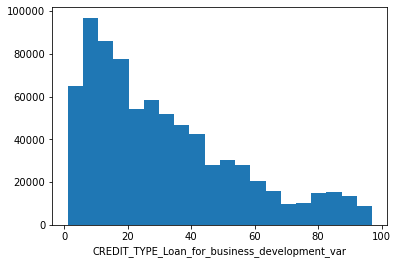


MONTHS_BALANCE_count :: log-transformed


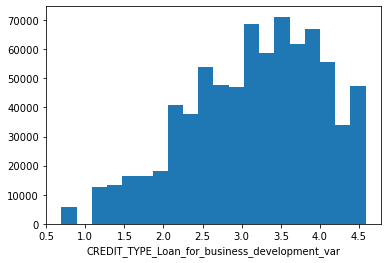

---
DAYS_CREDIT


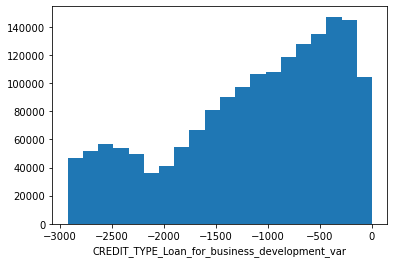


DAYS_CREDIT :: log-transformed


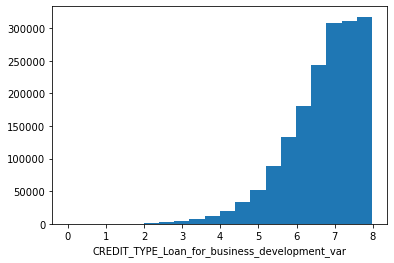

---
CREDIT_DAY_OVERDUE


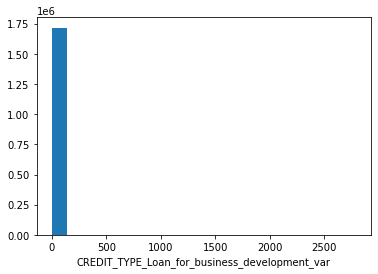


CREDIT_DAY_OVERDUE :: log-transformed


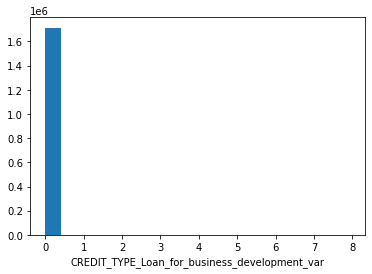

---
DAYS_ENDDATE_FACT


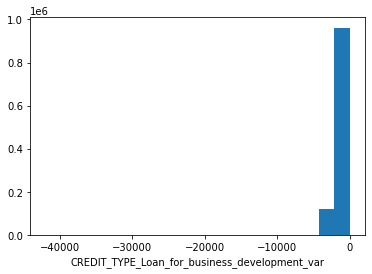


DAYS_ENDDATE_FACT :: log-transformed


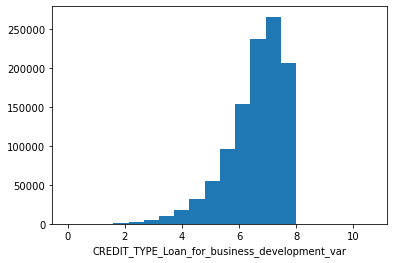

In [49]:
for i in ['MONTHS_BALANCE_count', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_ENDDATE_FACT']:
    print('---')
    print(f'{i}')
    plt.hist(bureau[i], bins=20)
    plt.xlabel(col)
    plt.show()
    print('')
    print(f'{i} :: log-transformed')
    plt.hist(np.log(bureau[i].abs() + 1), bins=20)
    plt.xlabel(col)
    plt.show()

In [82]:
def num_plot(data, num_cols, remove=["Id"], hist_bins=10, figsize=(20, 4)):

    if len(remove) > 0:
        num_cols2 = [x for x in num_cols if (x not in remove)]

    for i in num_cols2:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        data.hist(str(i), bins=hist_bins, ax=axes[0])
        data.boxplot(str(i), ax=axes[1], vert=False);
        try:
            sns.kdeplot(np.array(data[str(i)]))
        except:
            ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()

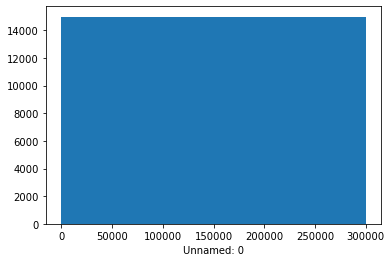

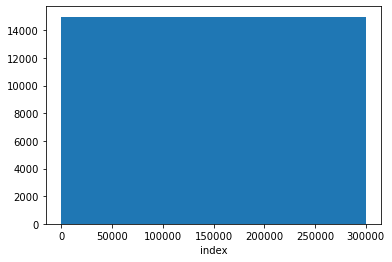

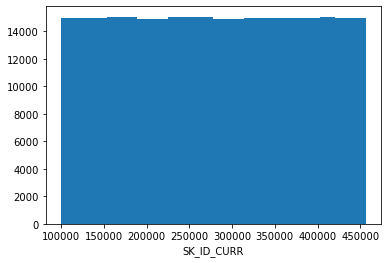

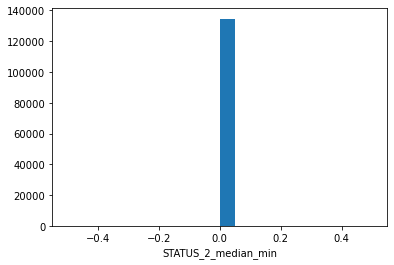

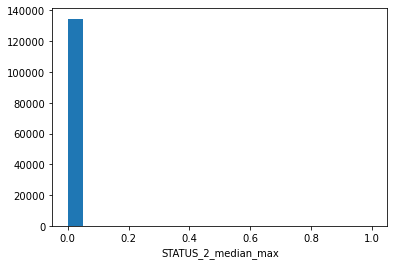

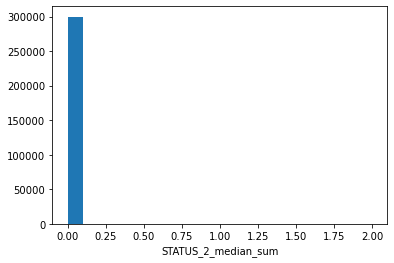

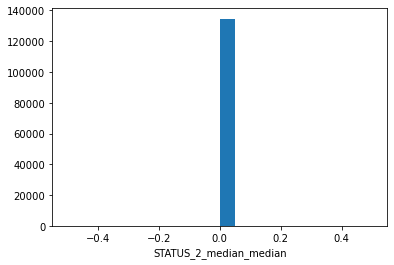

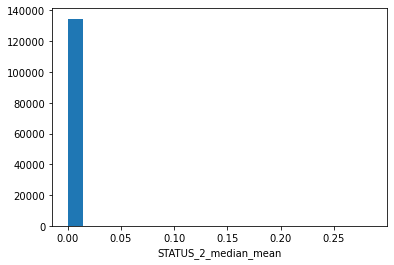

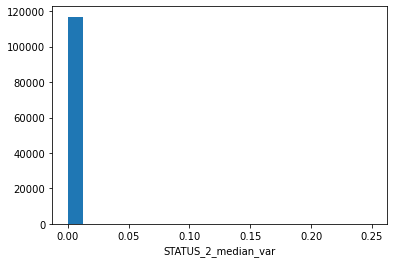

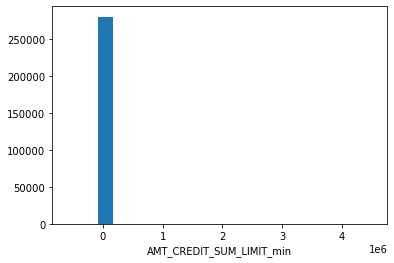

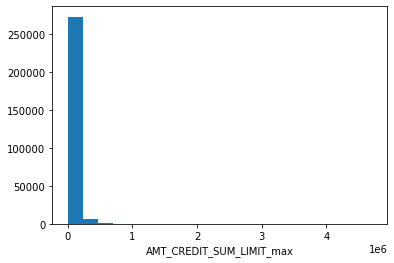

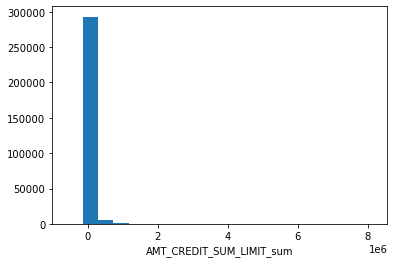

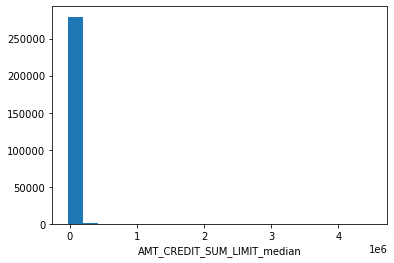

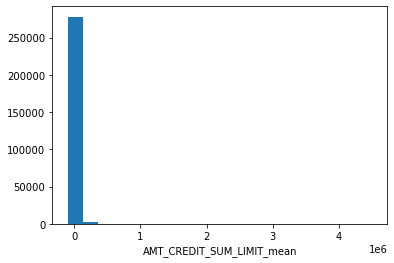

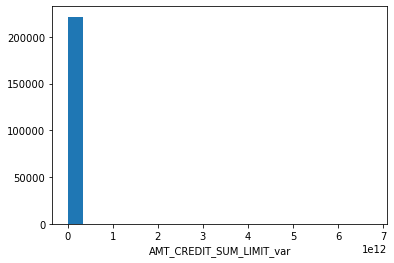

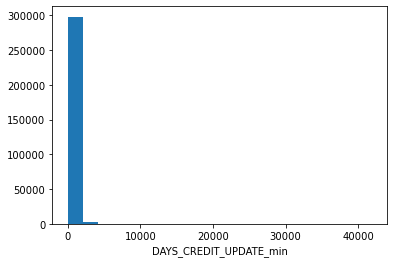

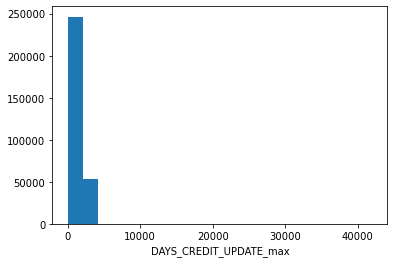

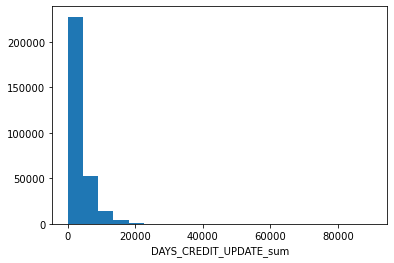

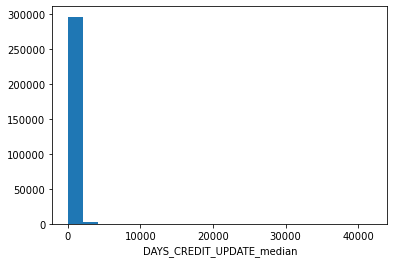

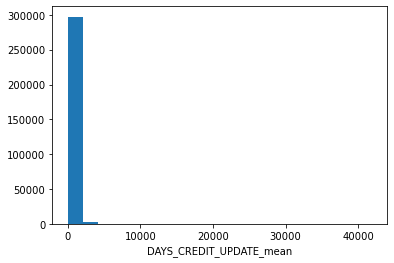

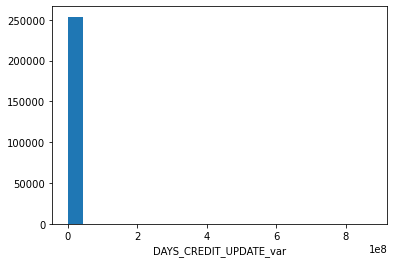

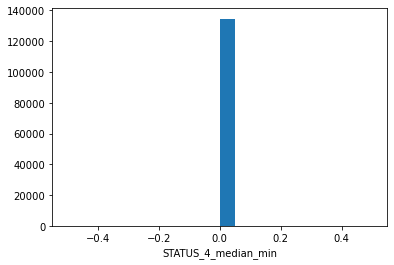

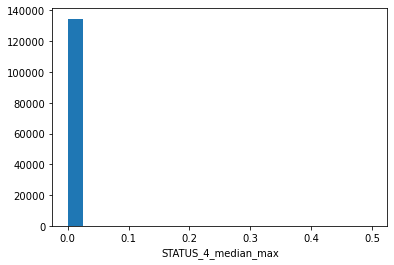

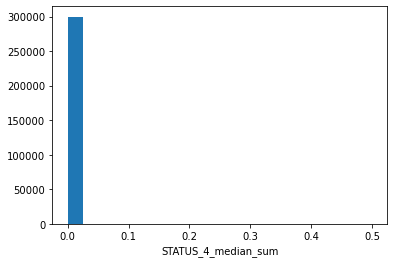

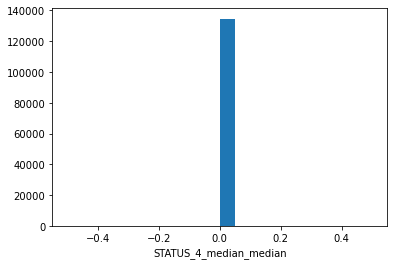

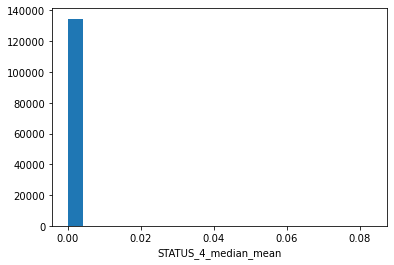

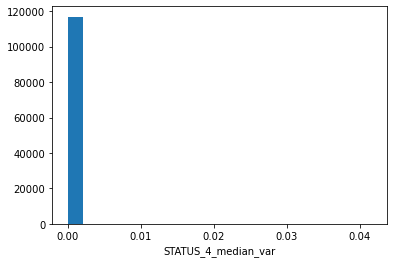

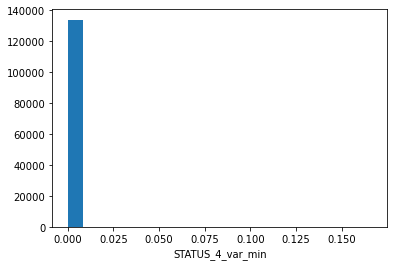

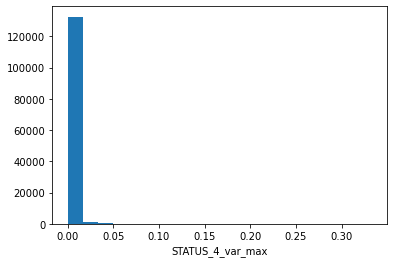

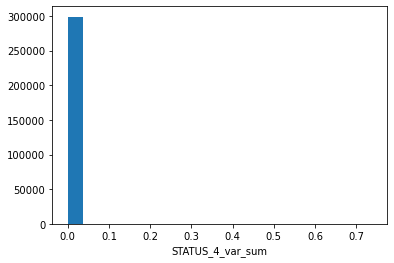

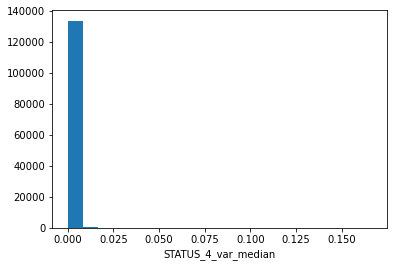

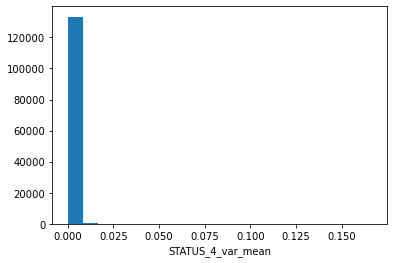

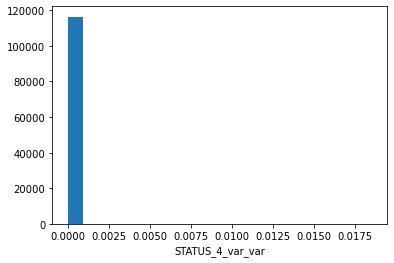

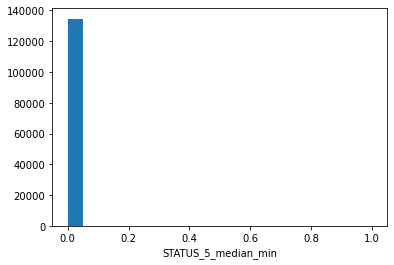

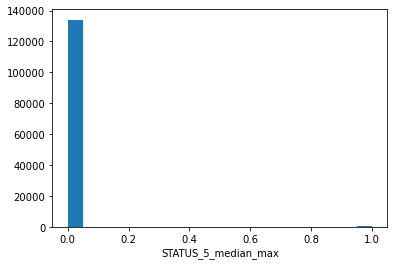

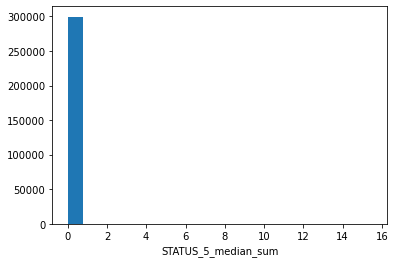

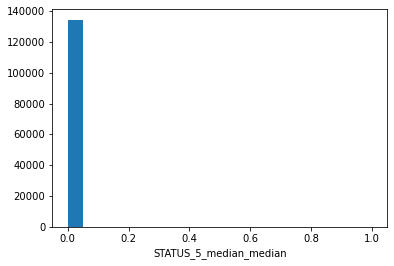

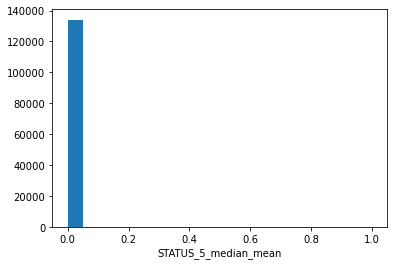

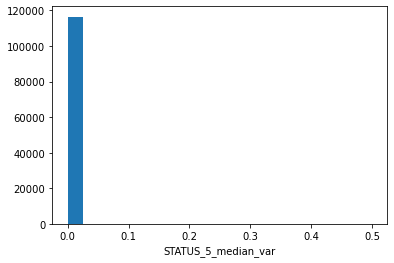

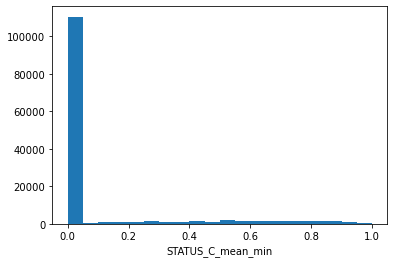

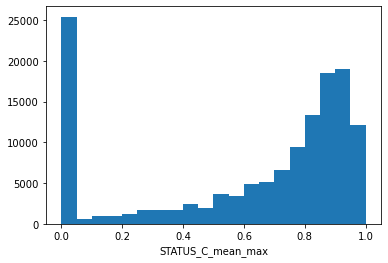

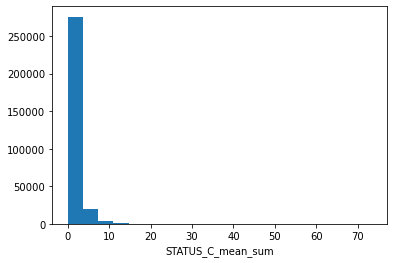

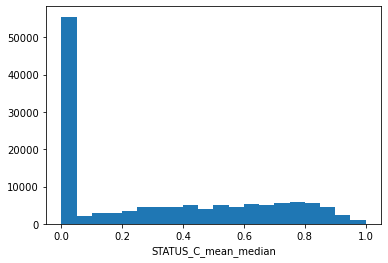

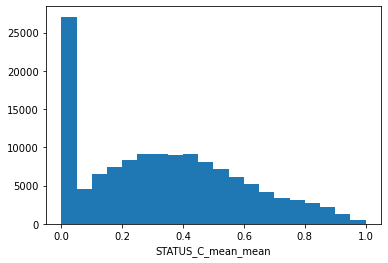

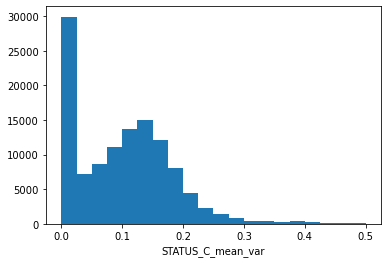

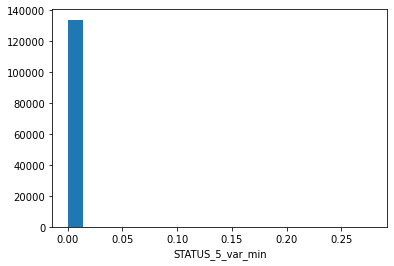

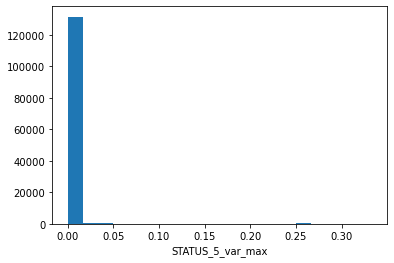

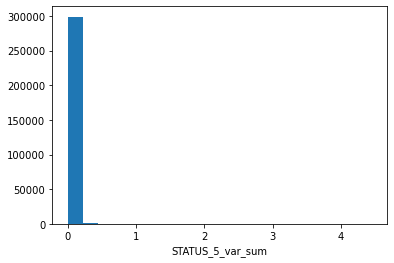

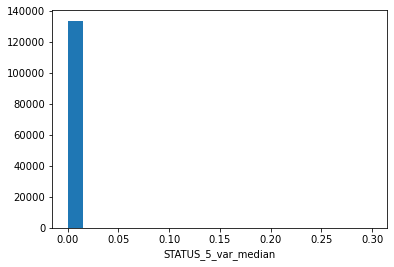

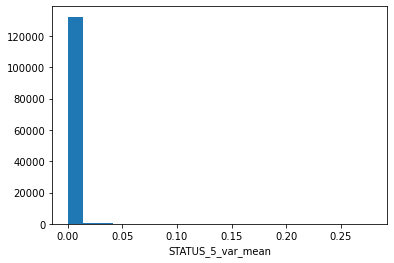

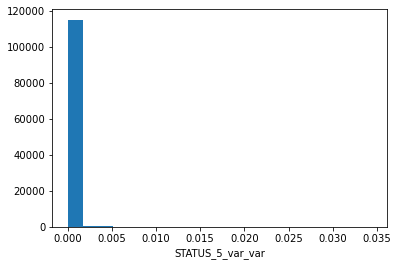

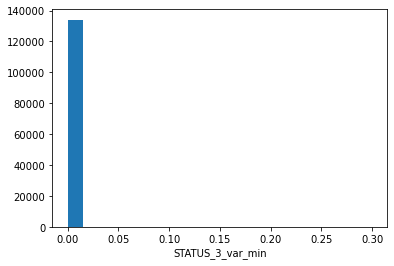

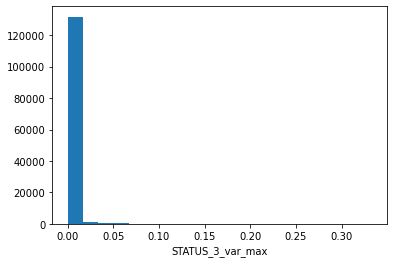

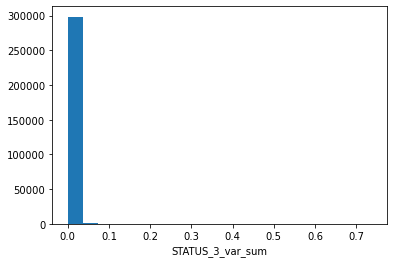

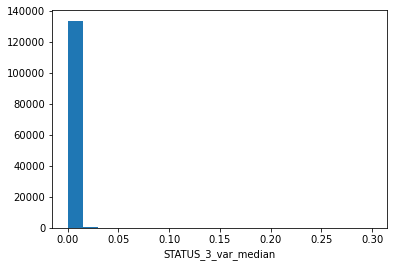

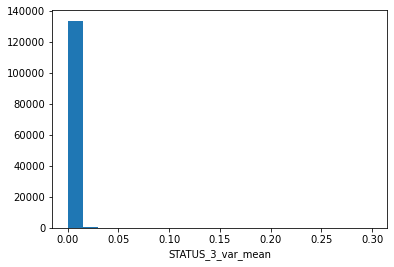

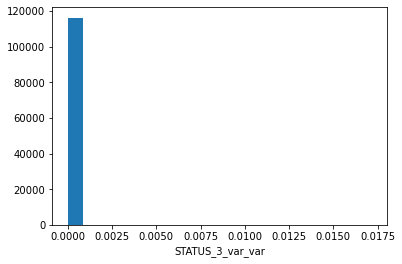

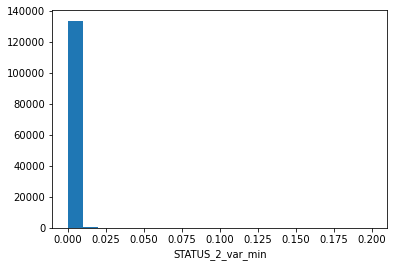

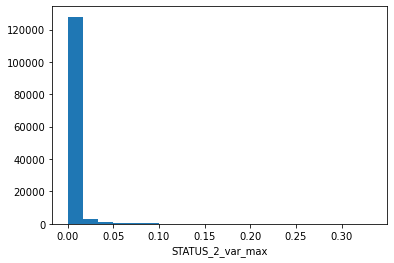

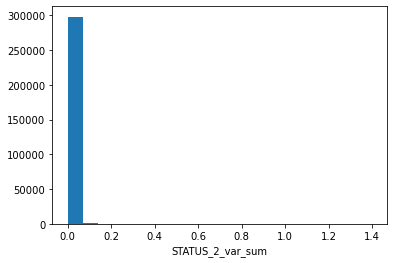

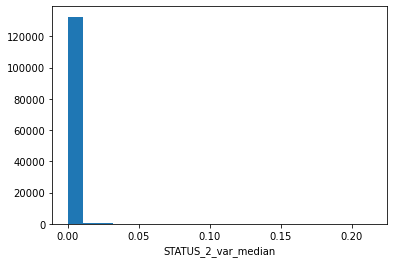

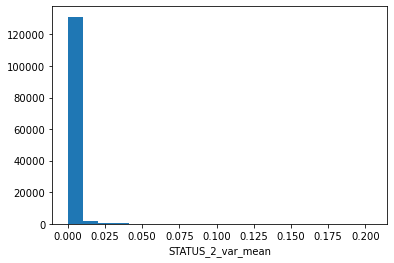

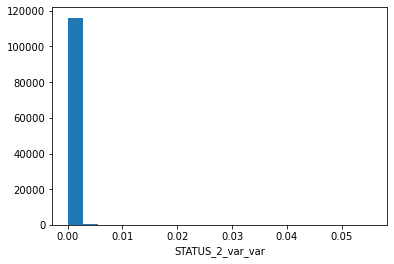

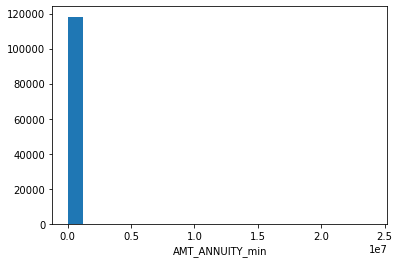

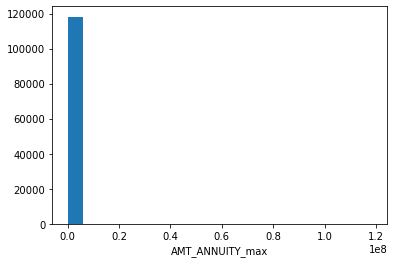

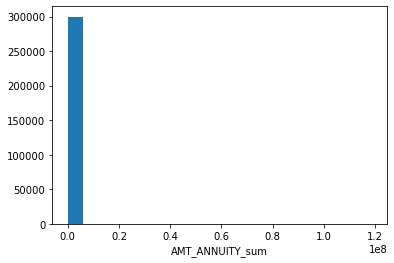

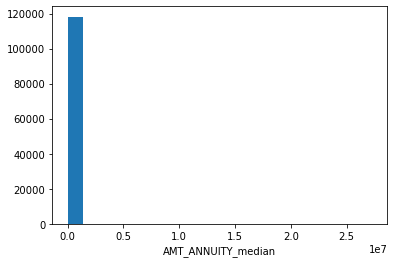

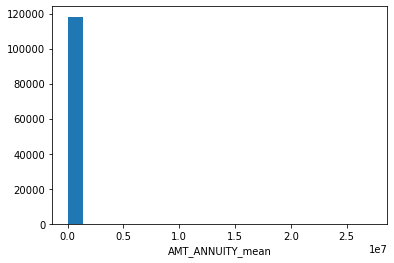

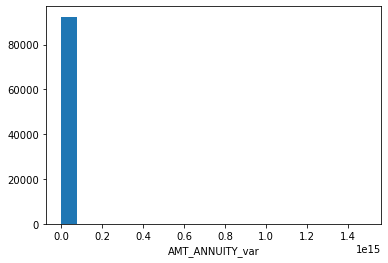

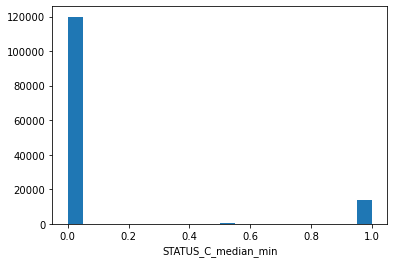

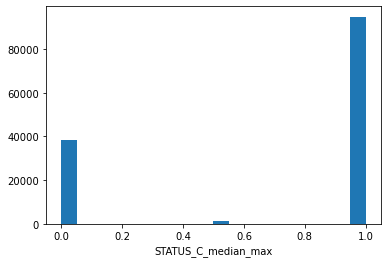

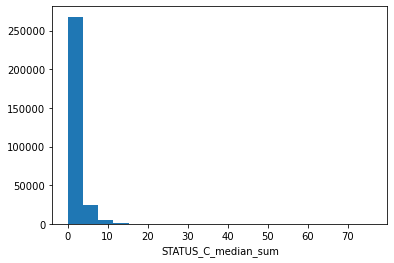

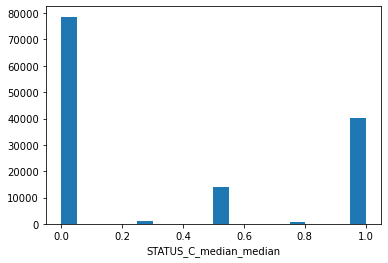

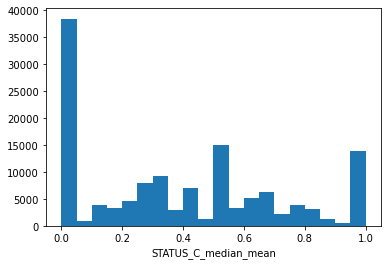

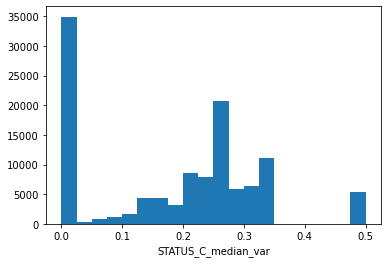

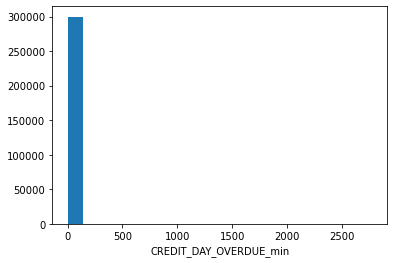

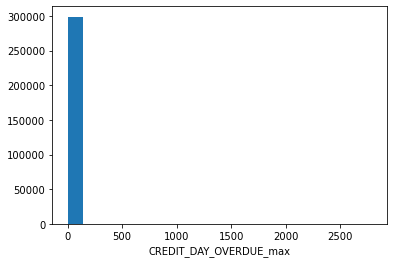

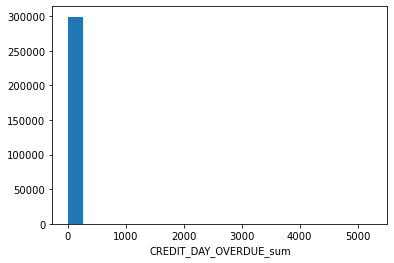

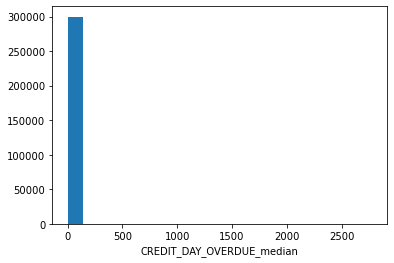

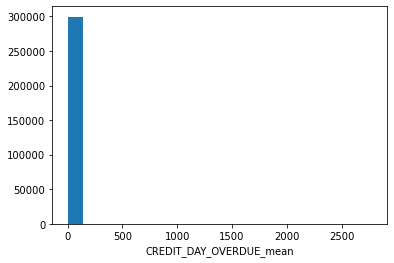

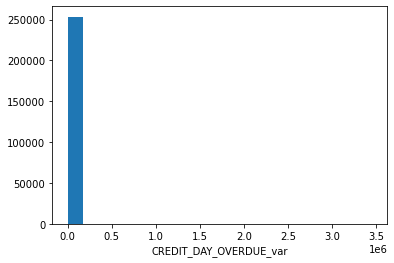

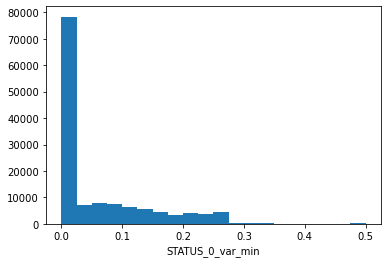

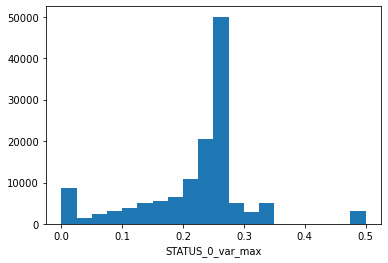

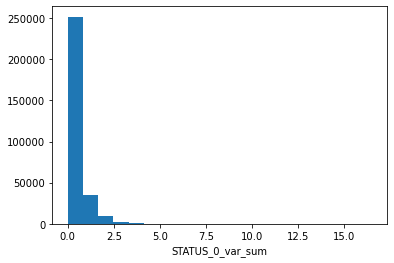

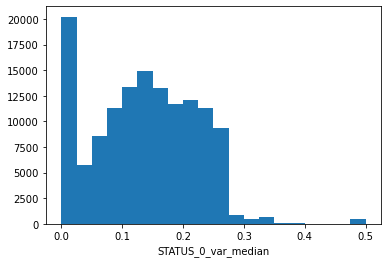

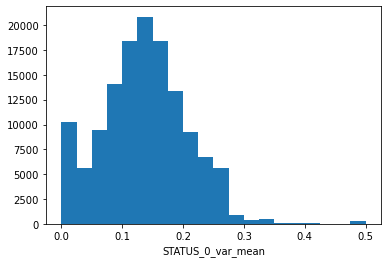

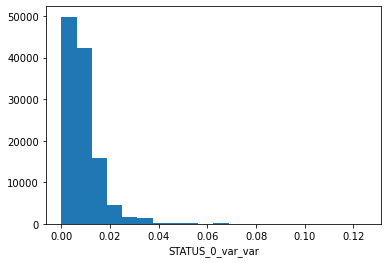

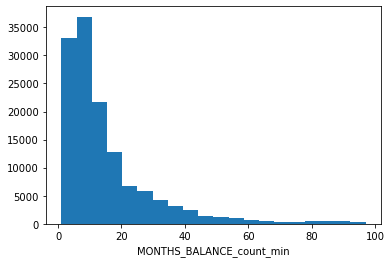

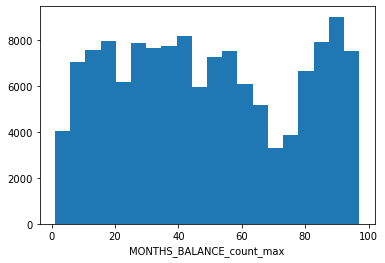

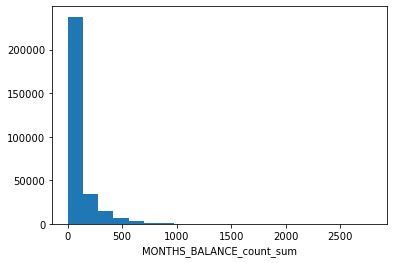

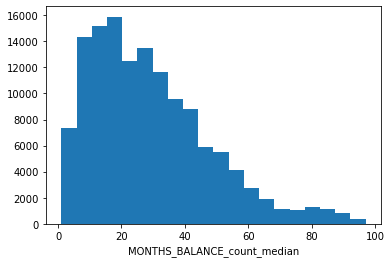

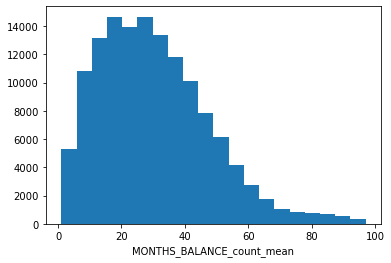

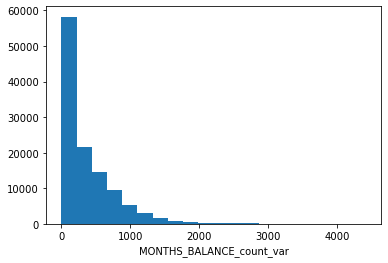

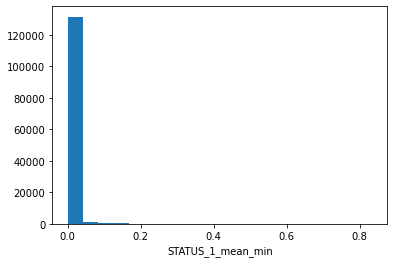

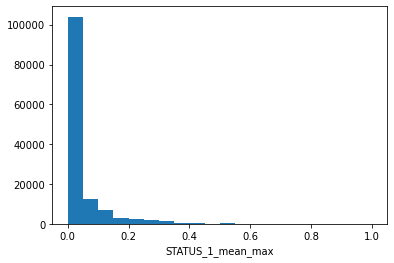

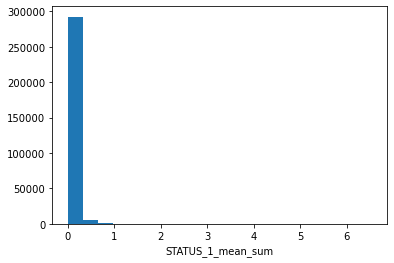

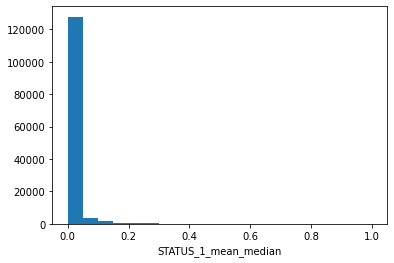

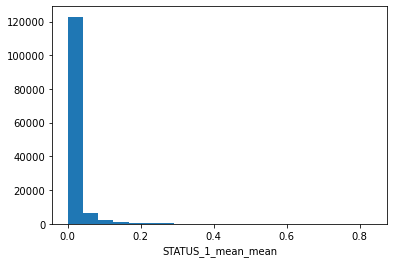

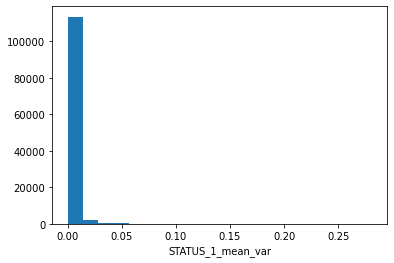

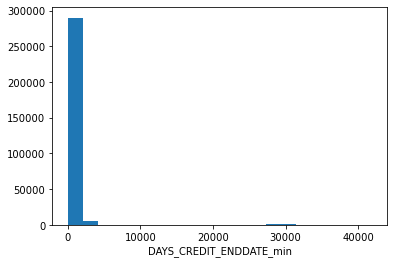

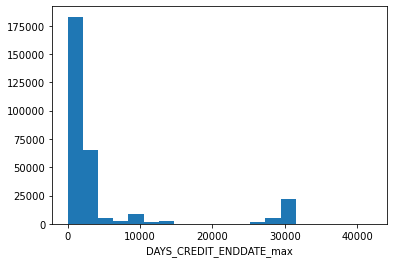

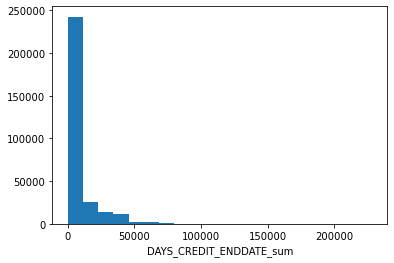

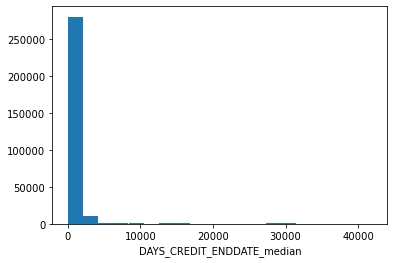

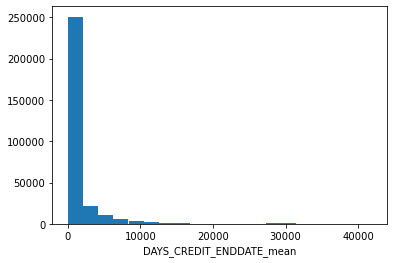

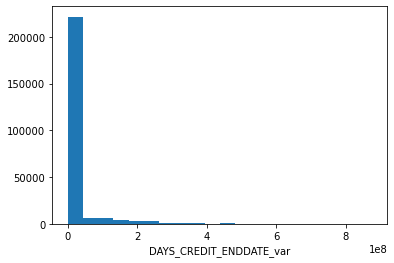

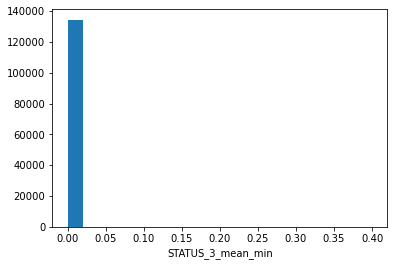

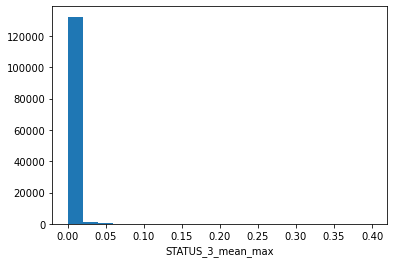

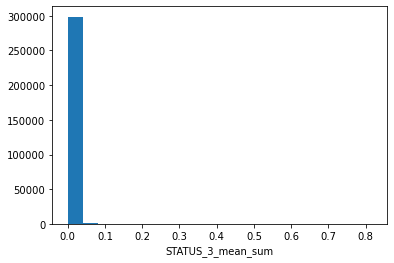

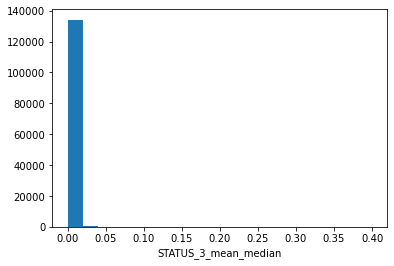

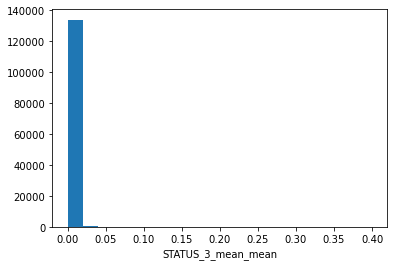

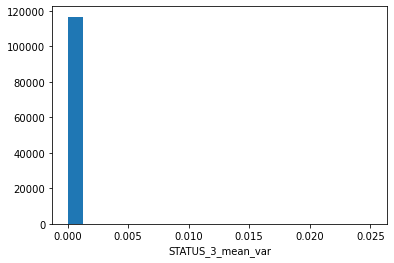

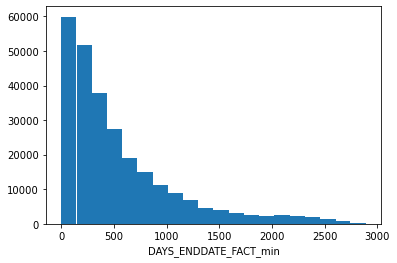

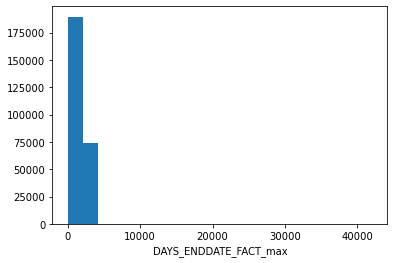

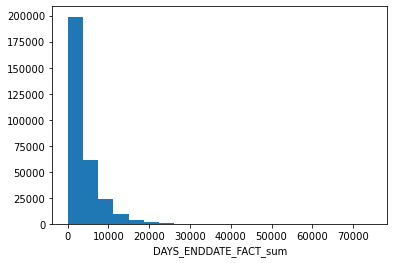

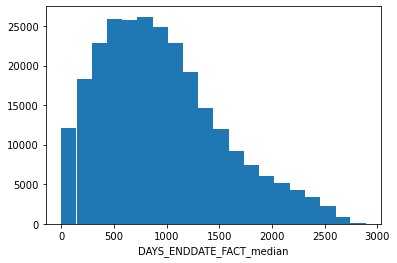

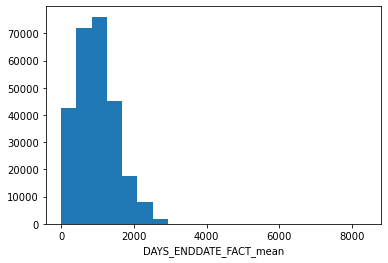

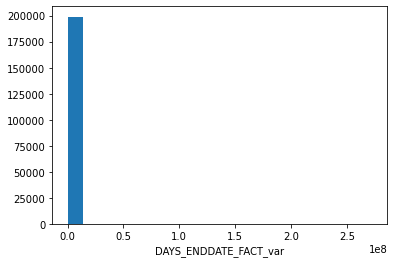

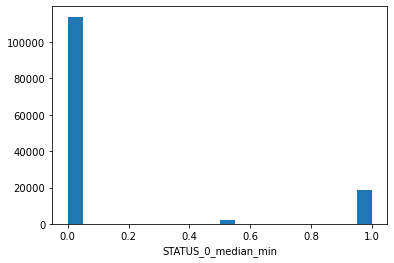

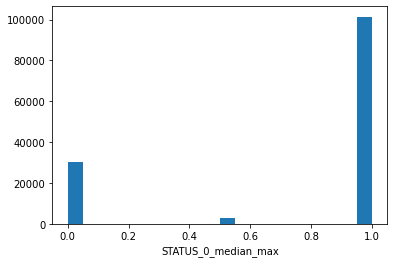

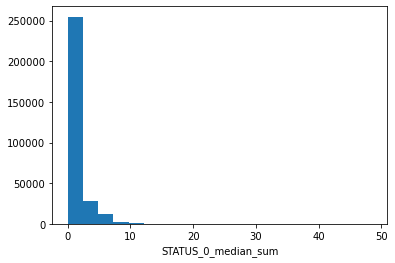

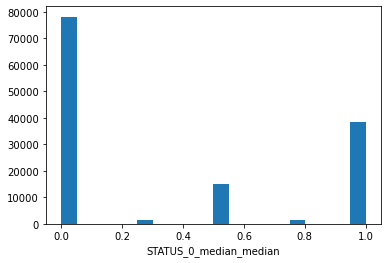

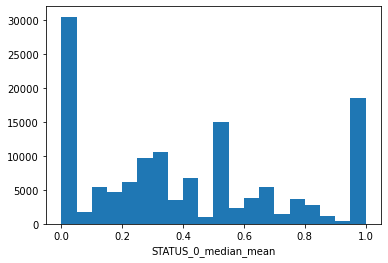

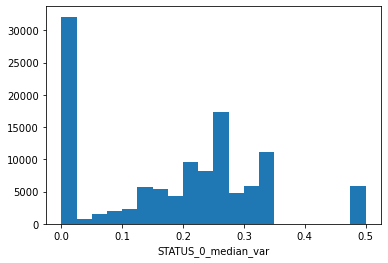

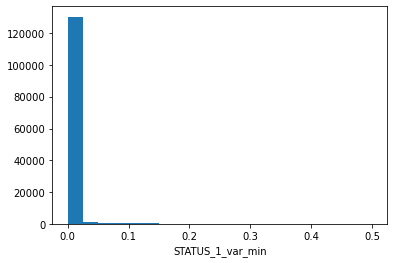

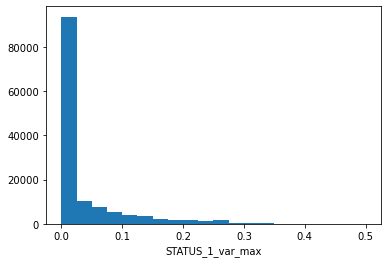

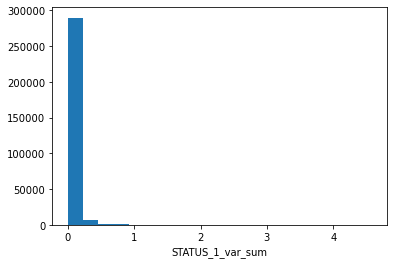

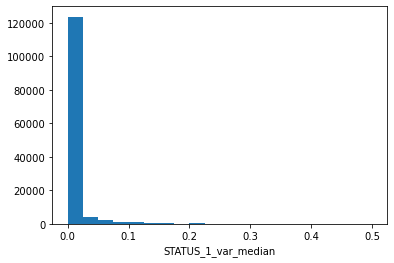

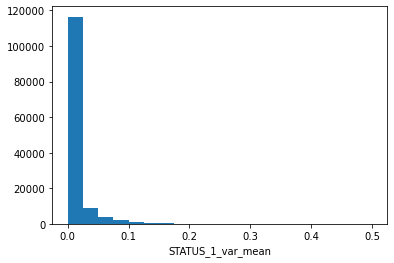

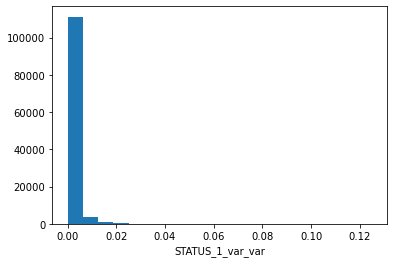

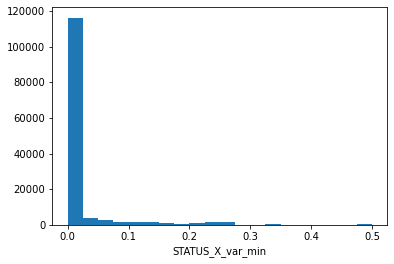

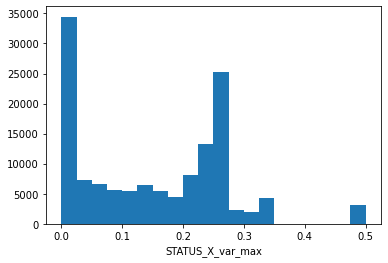

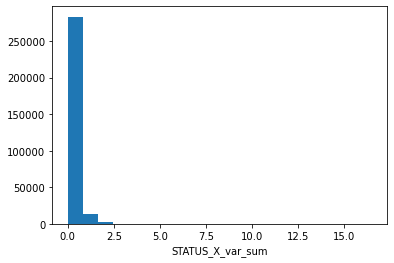

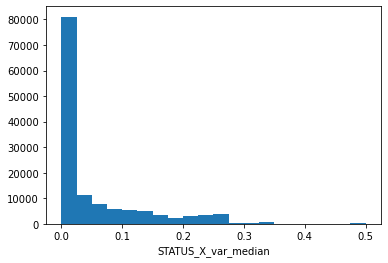

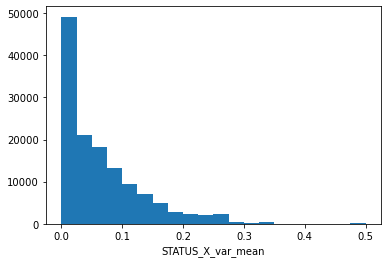

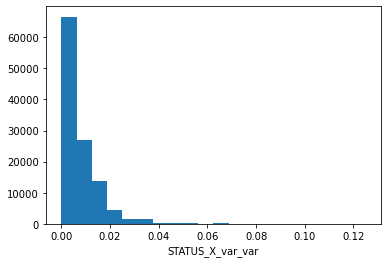

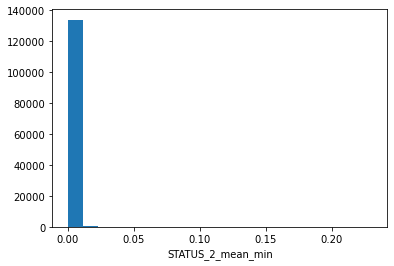

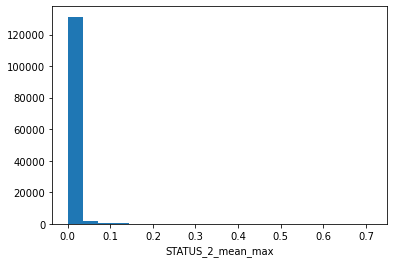

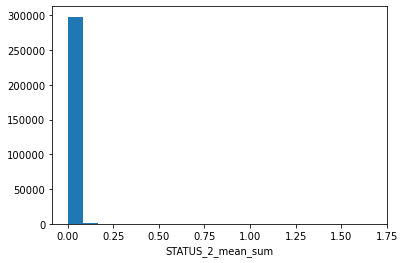

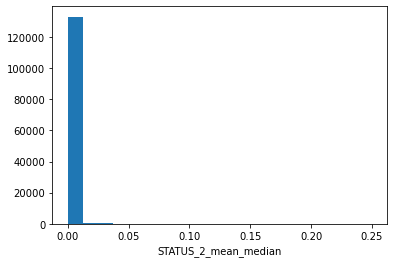

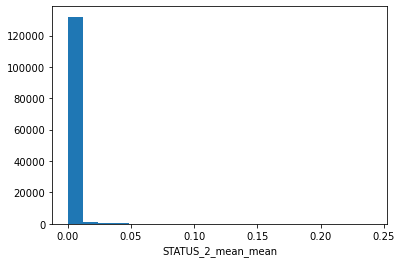

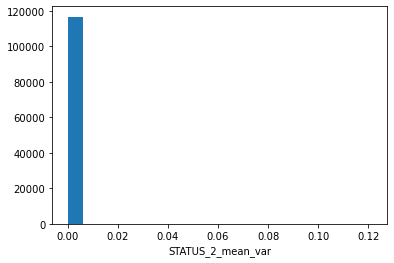

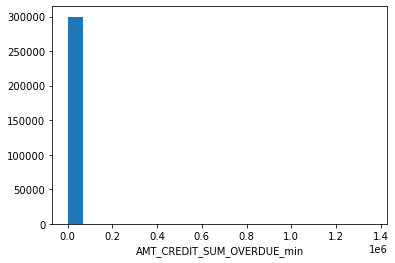

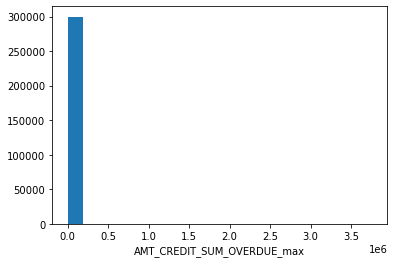

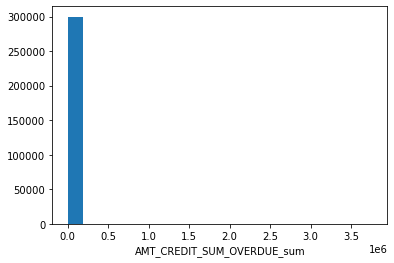

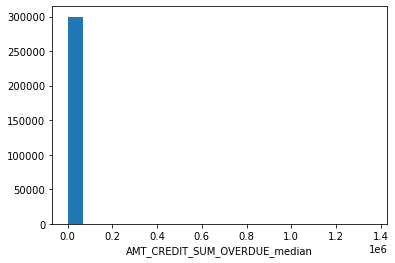

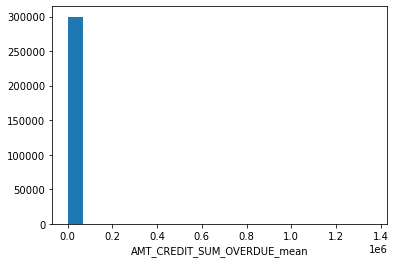

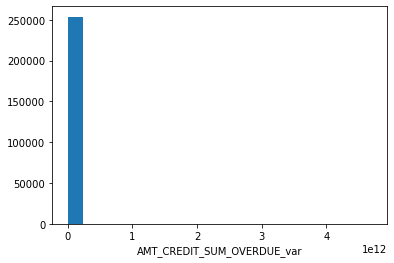

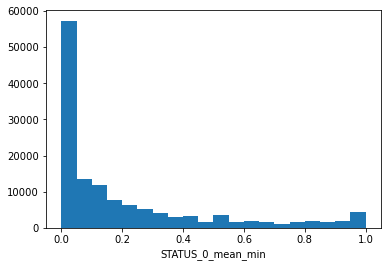

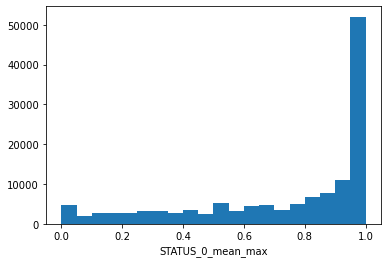

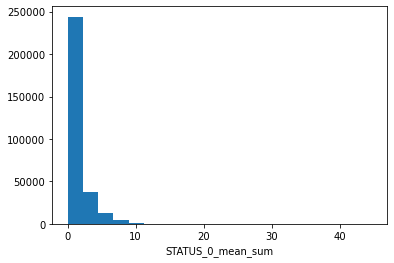

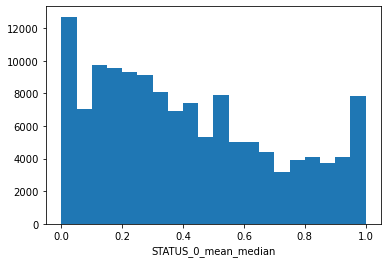

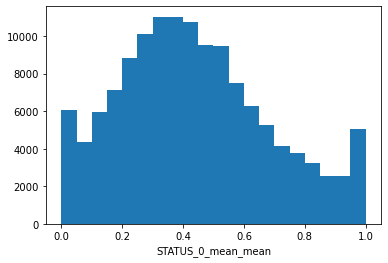

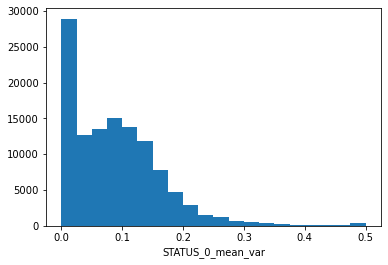

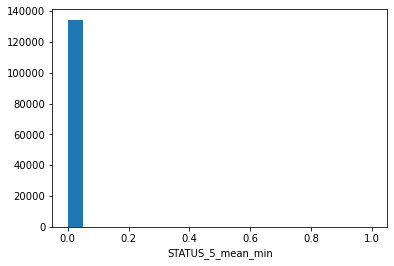

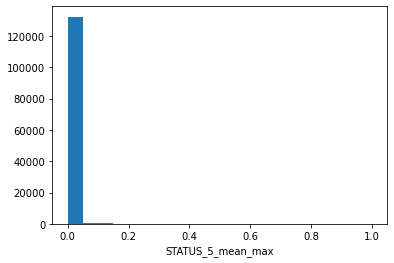

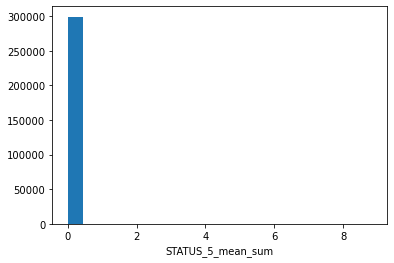

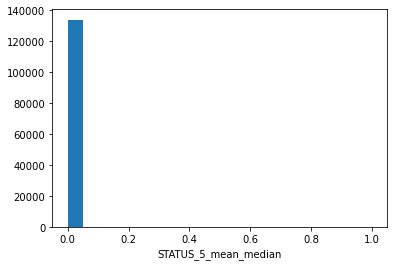

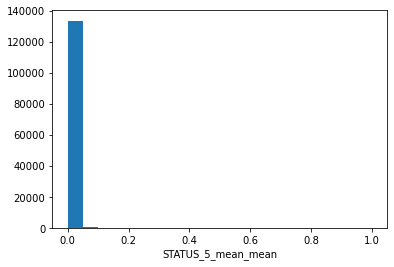

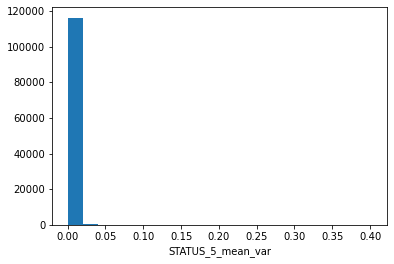

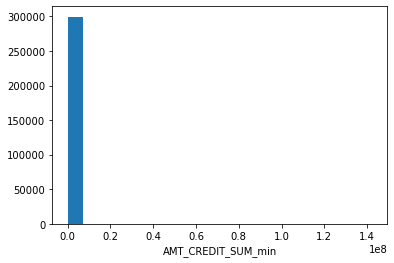

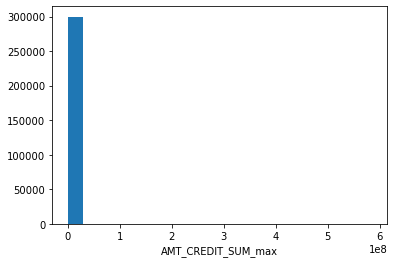

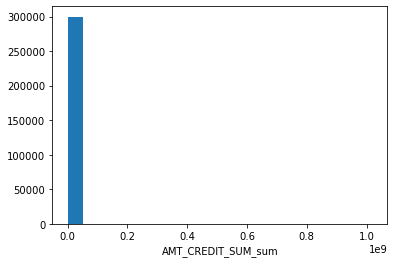

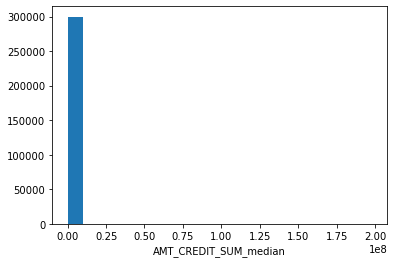

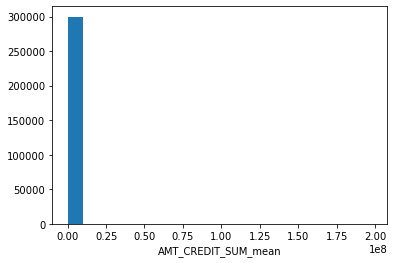

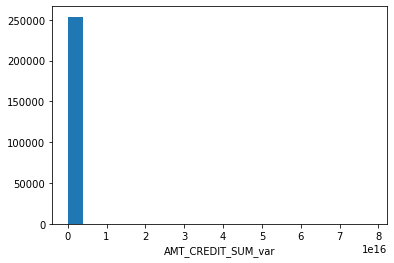

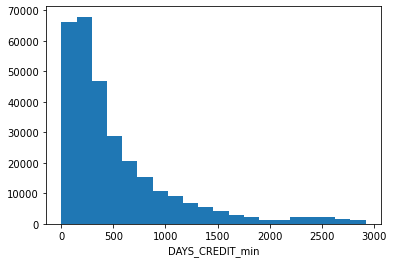

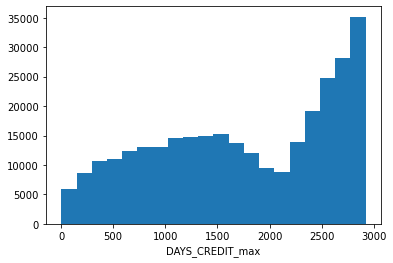

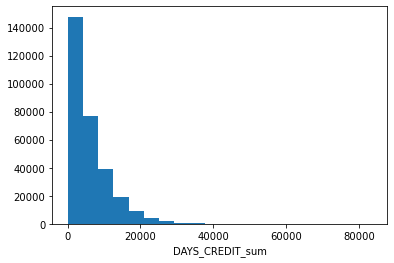

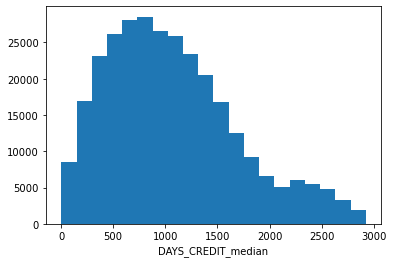

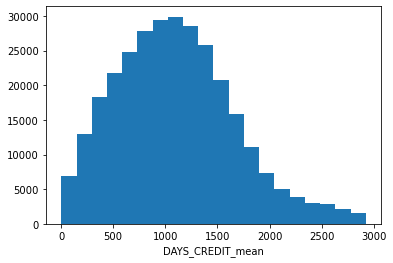

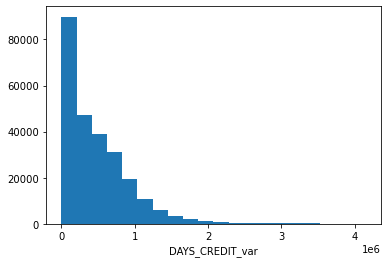

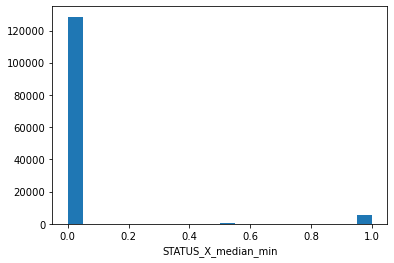

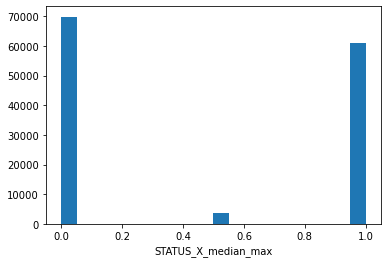

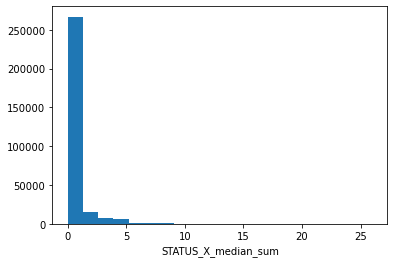

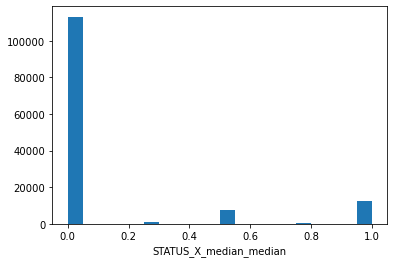

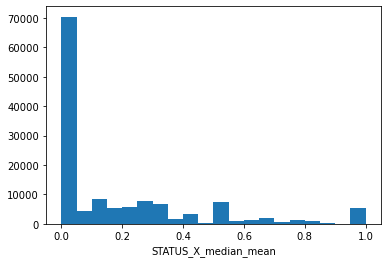

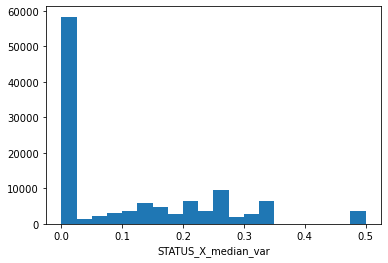

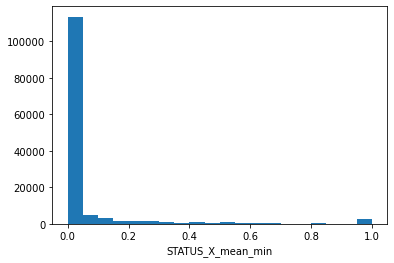

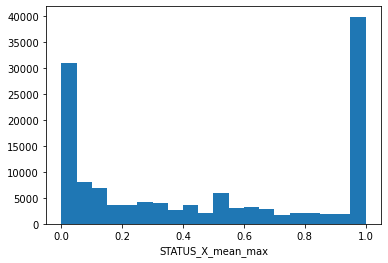

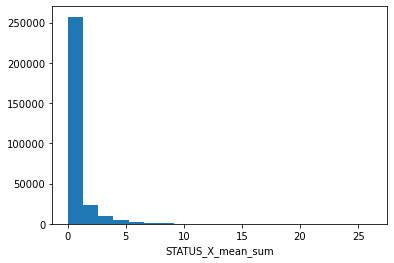

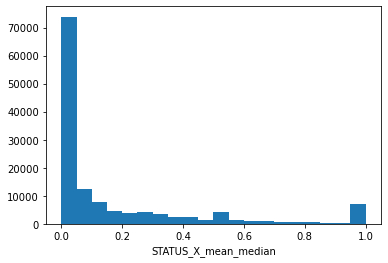

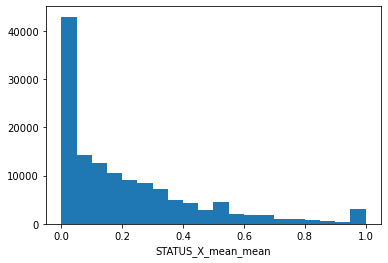

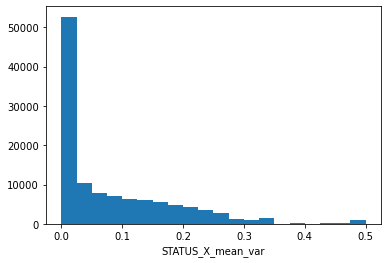

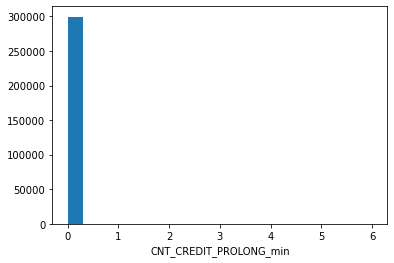

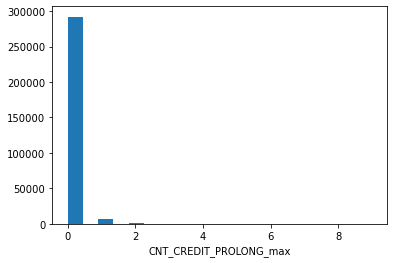

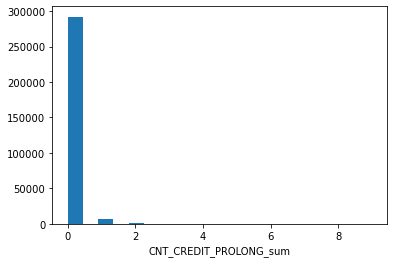

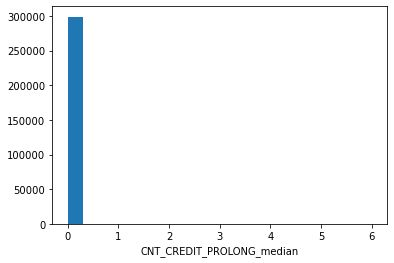

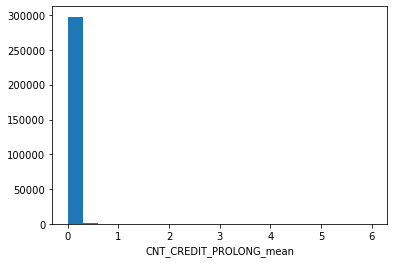

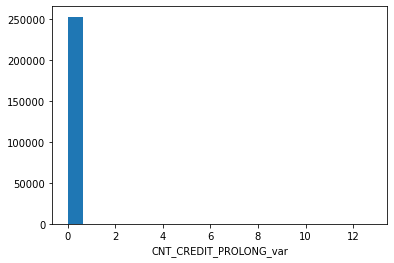

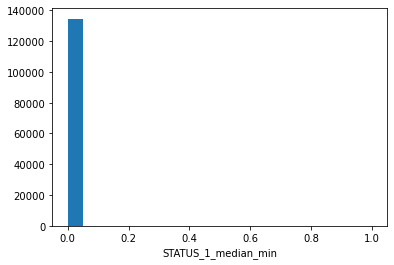

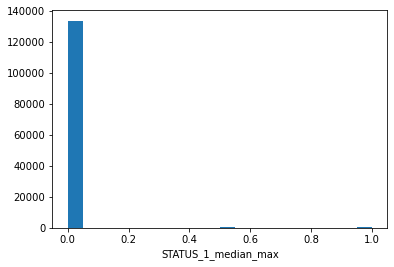

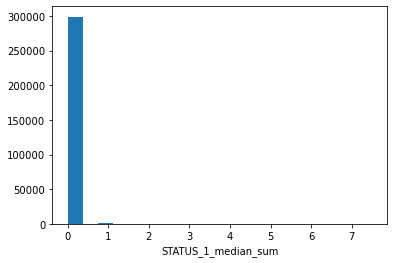

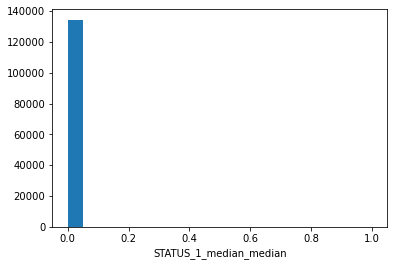

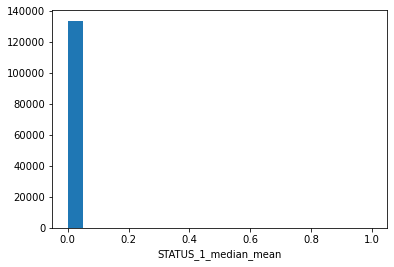

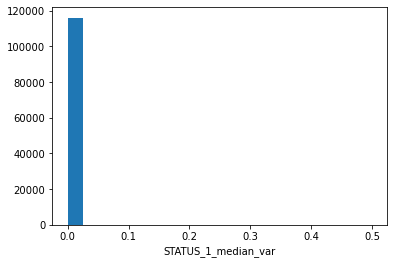

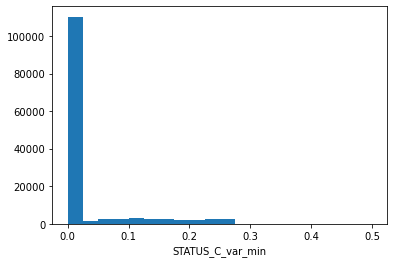

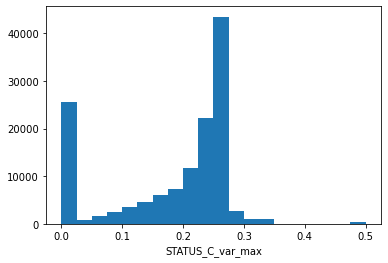

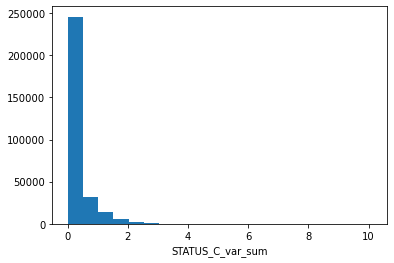

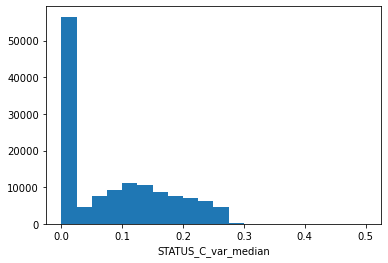

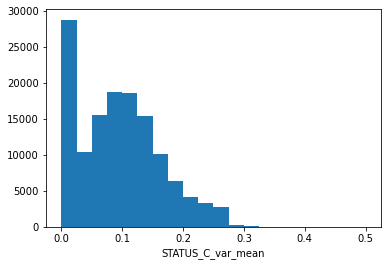

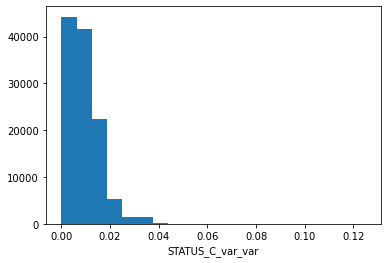

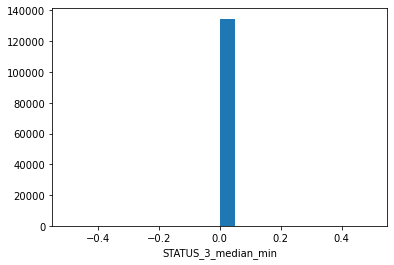

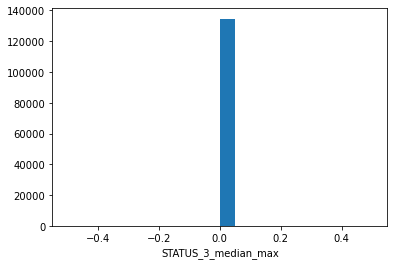

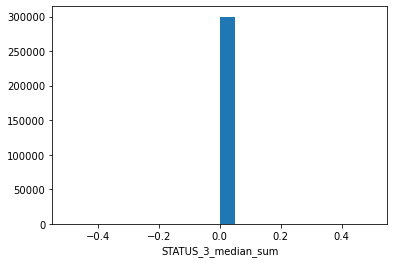

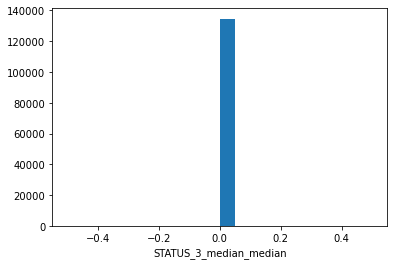

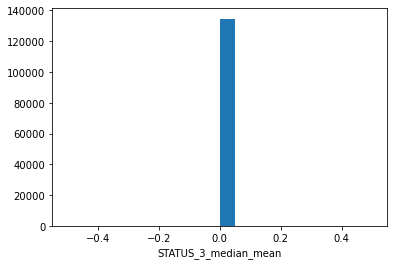

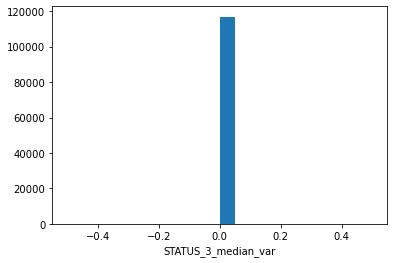

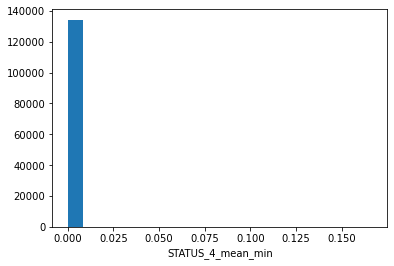

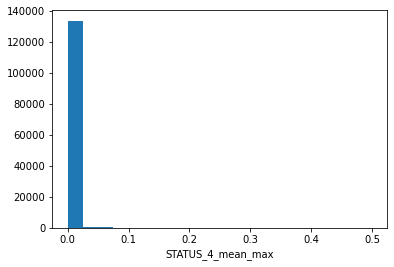

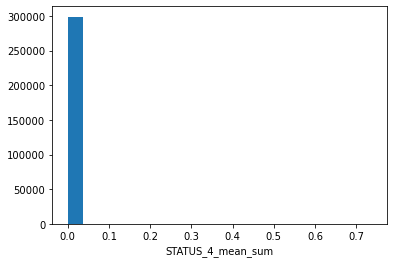

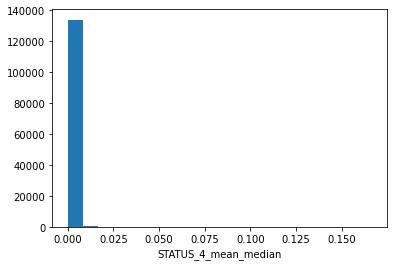

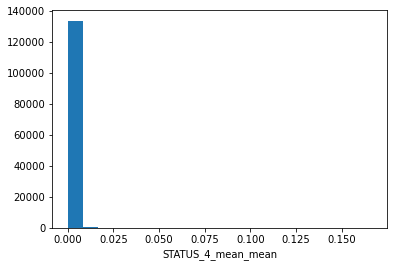

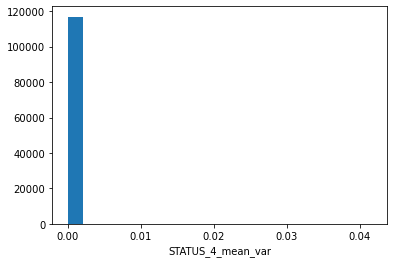

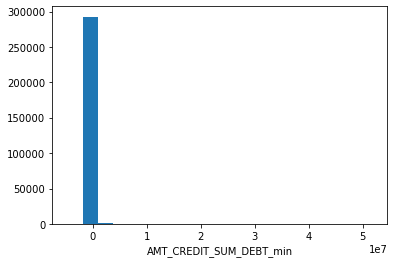

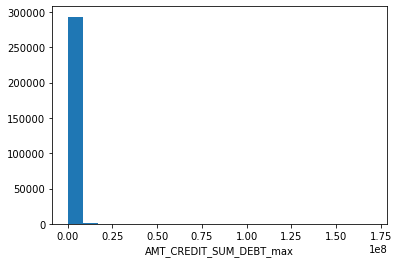

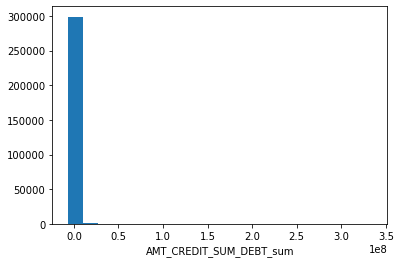

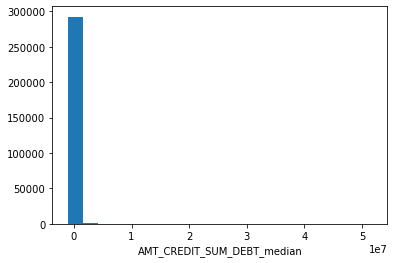

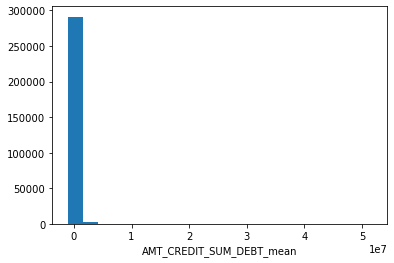

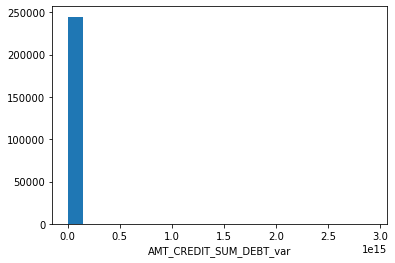

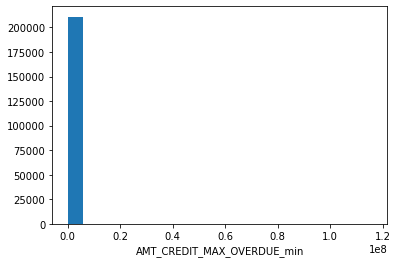

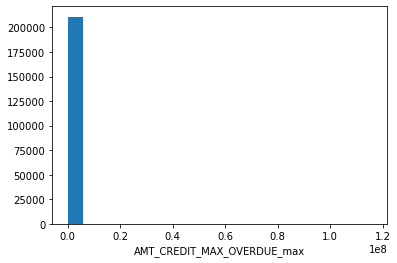

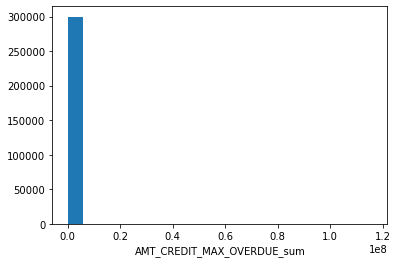

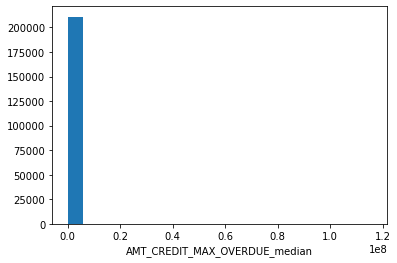

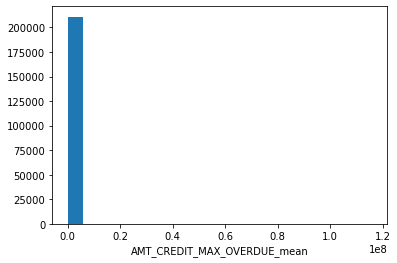

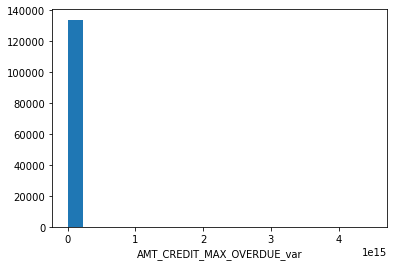

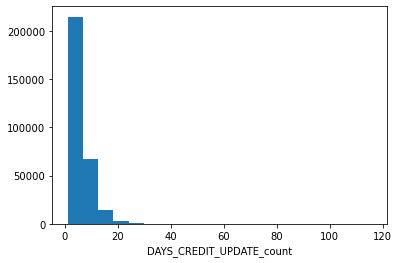

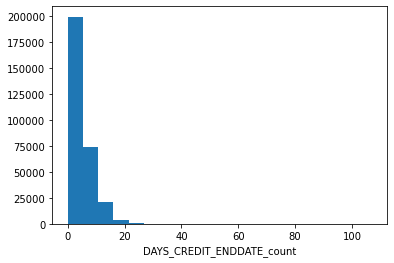

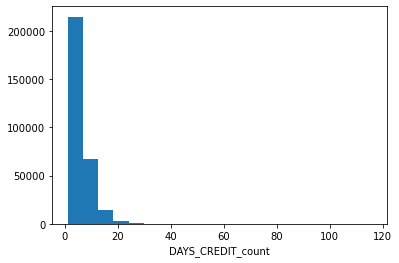

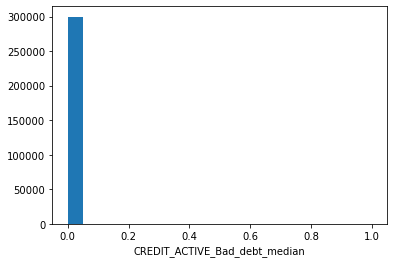

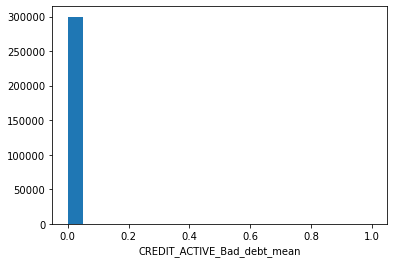

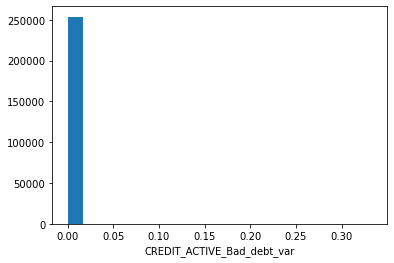

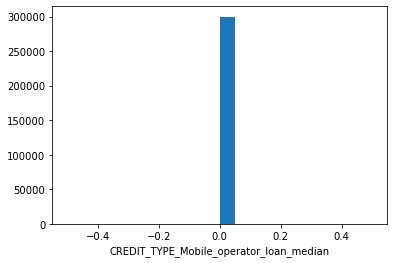

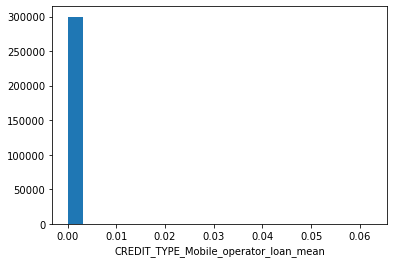

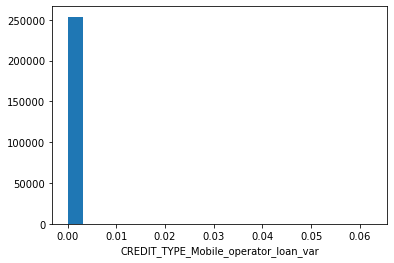

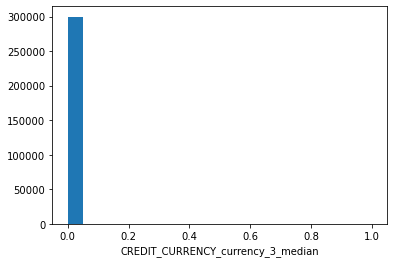

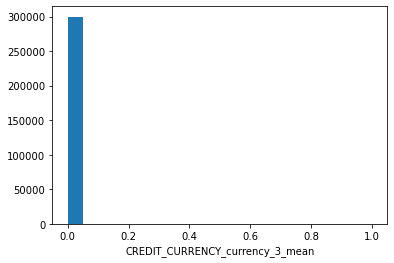

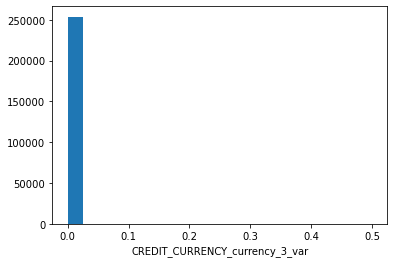

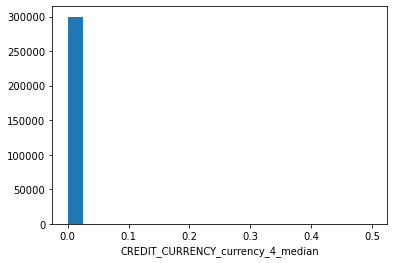

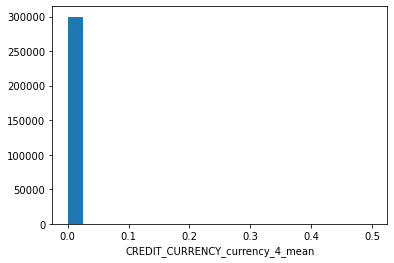

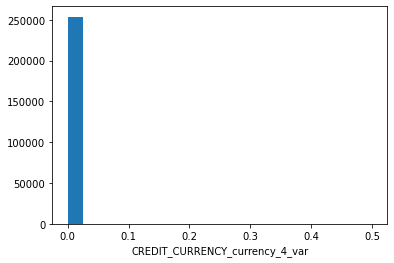

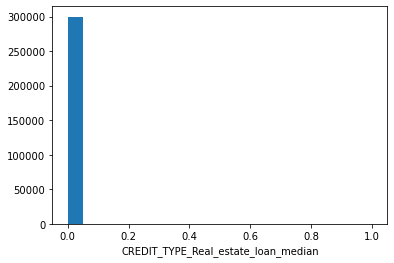

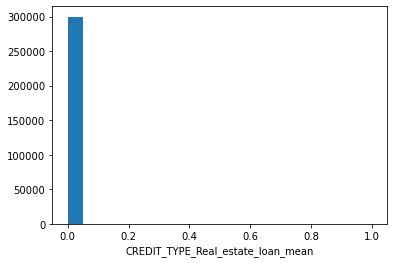

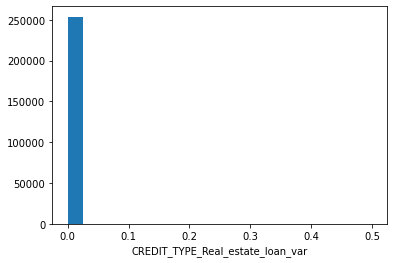

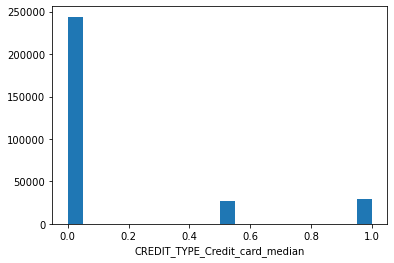

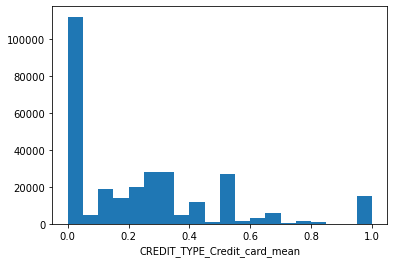

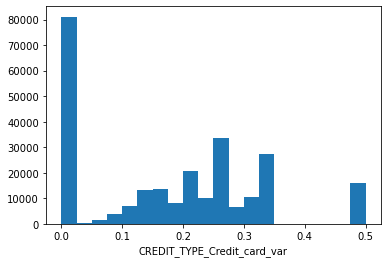

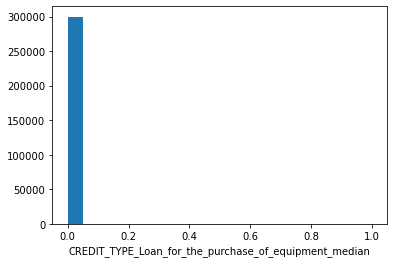

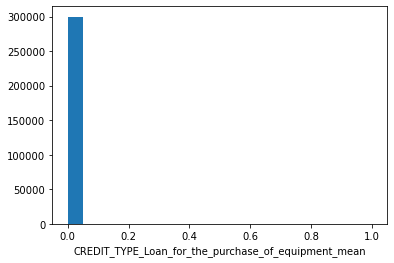

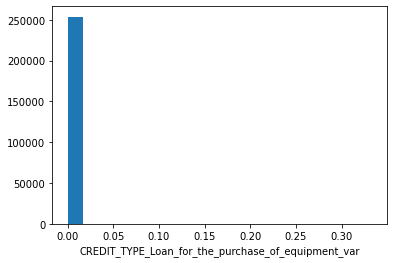

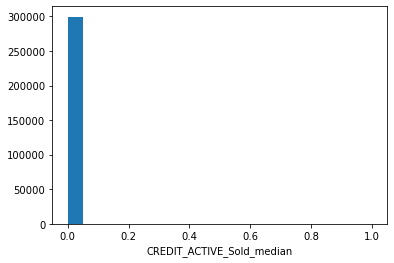

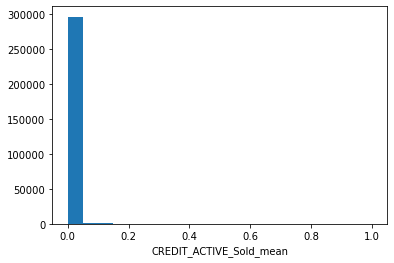

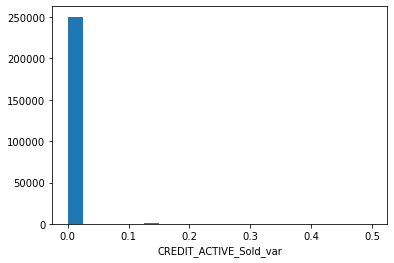

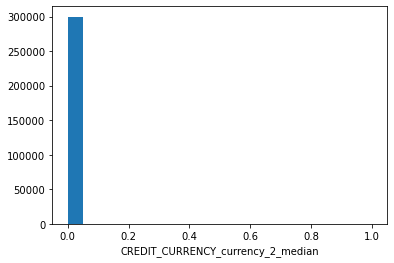

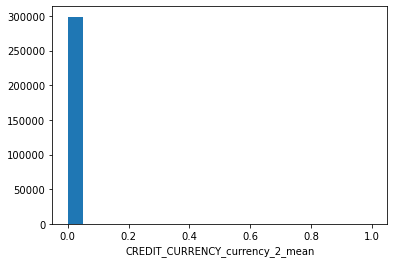

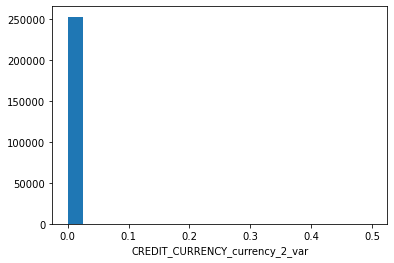

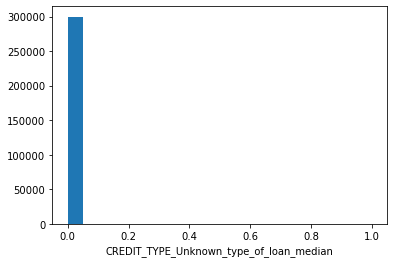

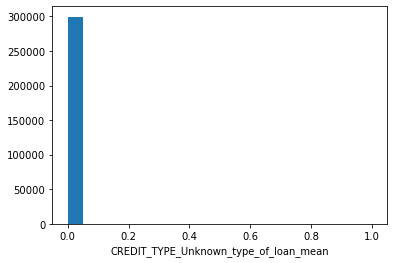

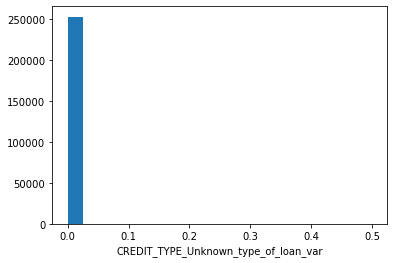

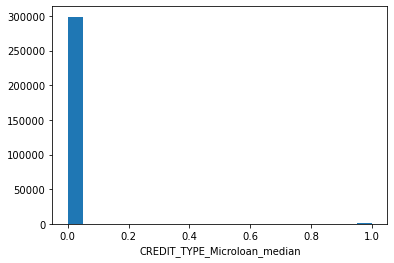

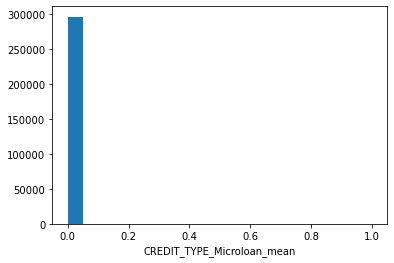

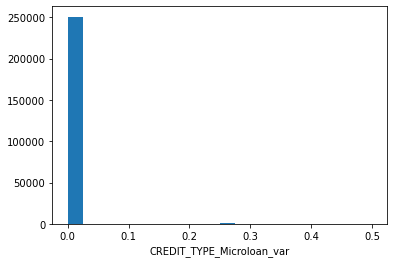

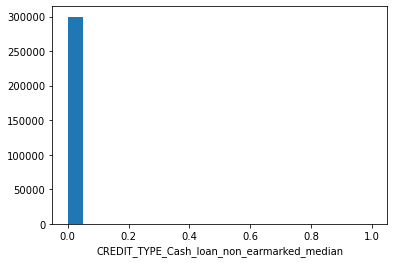

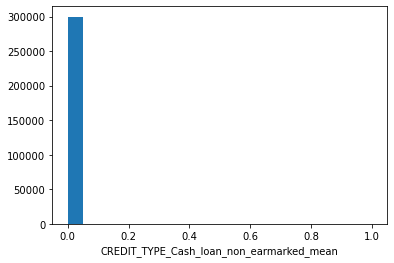

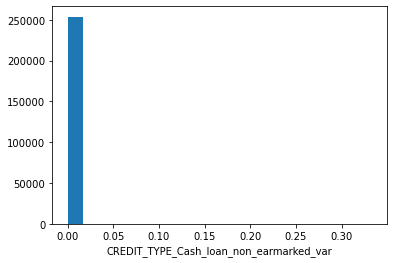

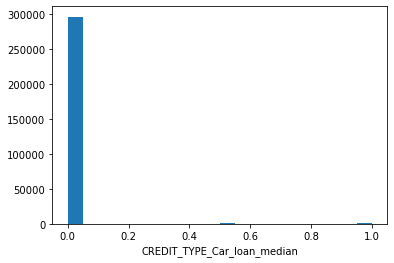

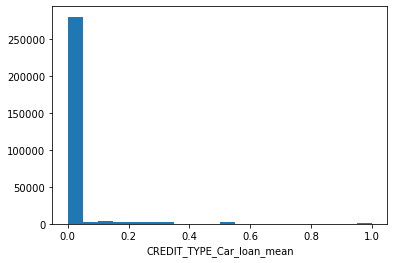

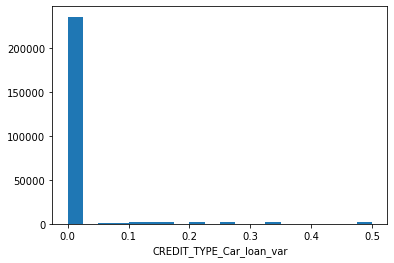

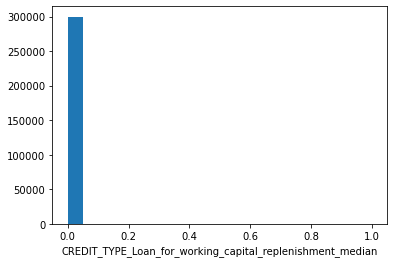

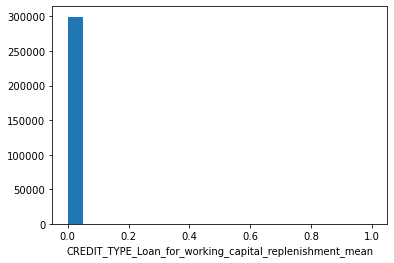

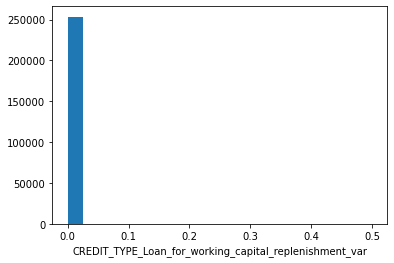

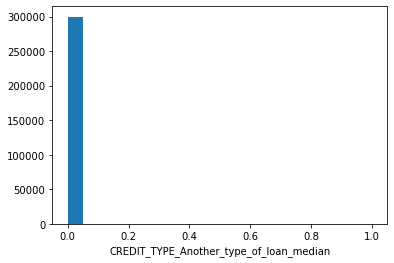

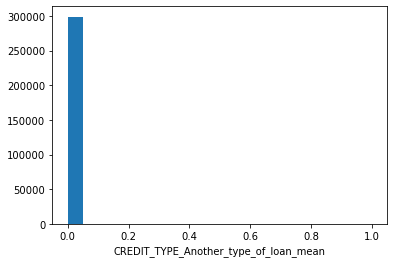

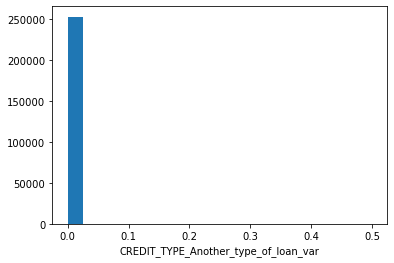

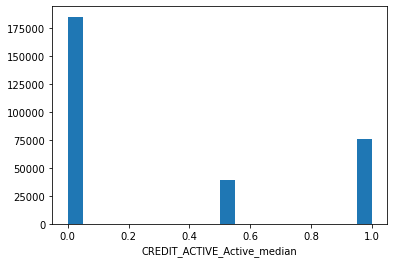

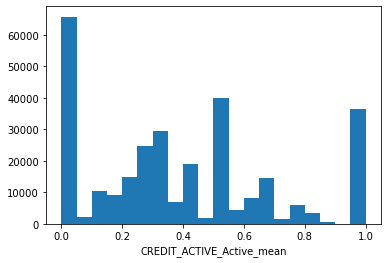

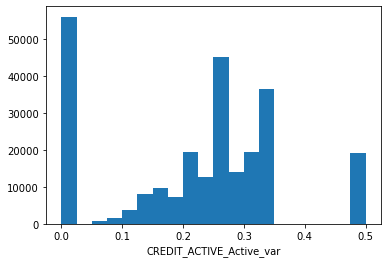

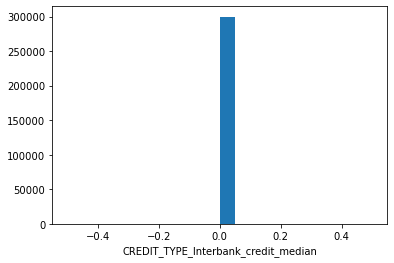

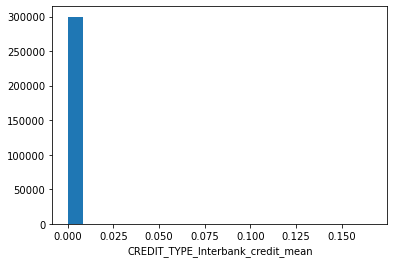

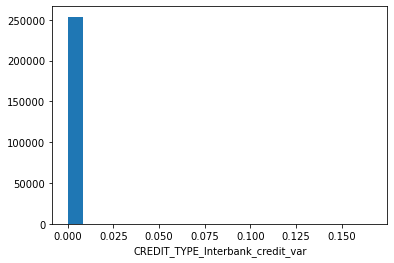

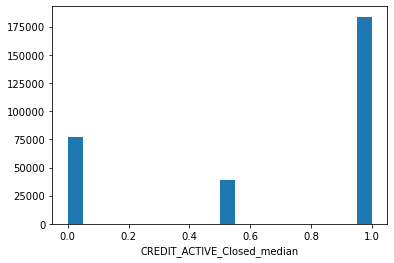

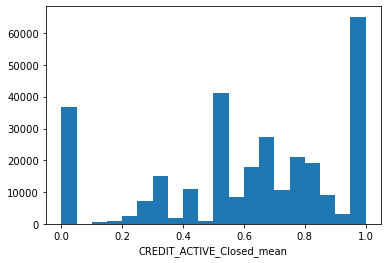

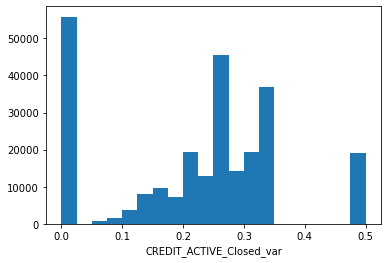

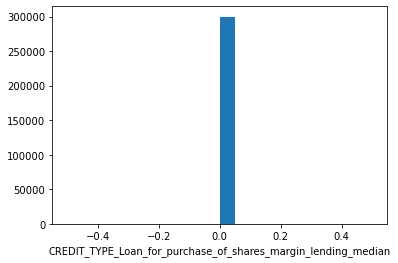

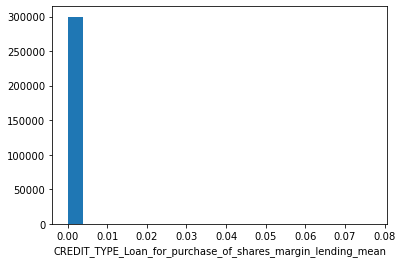

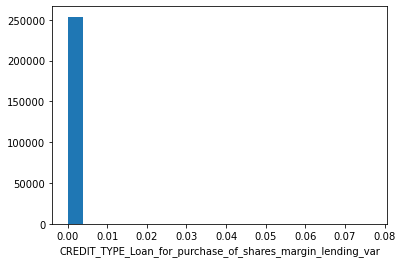

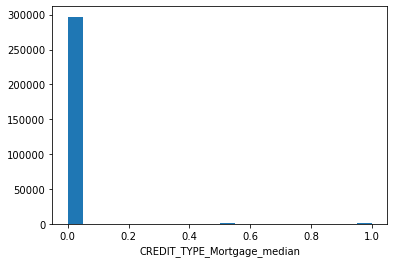

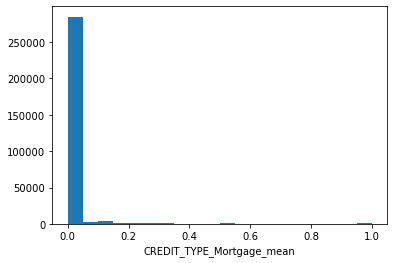

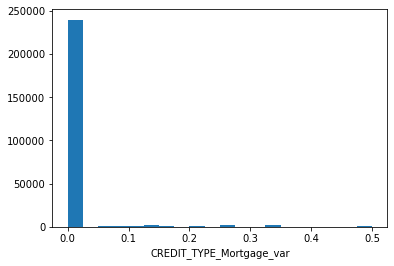

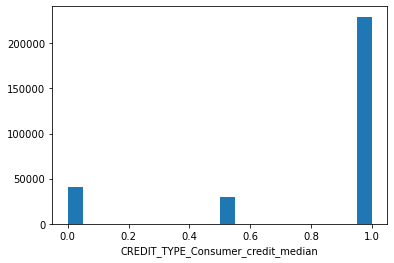

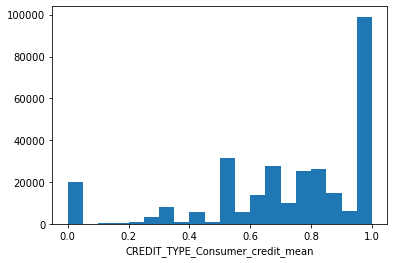

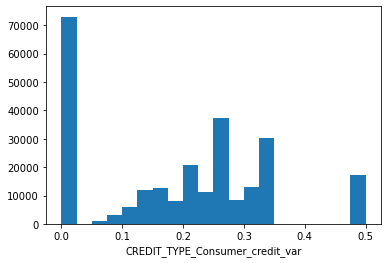

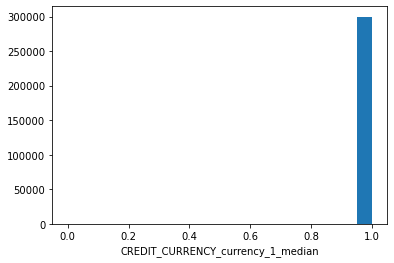

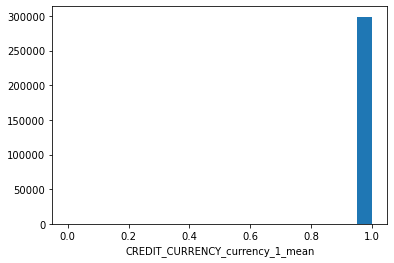

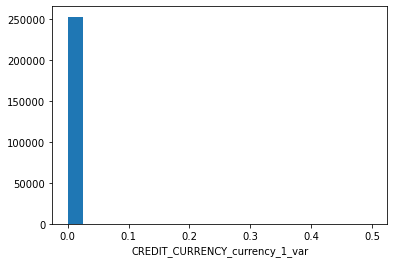

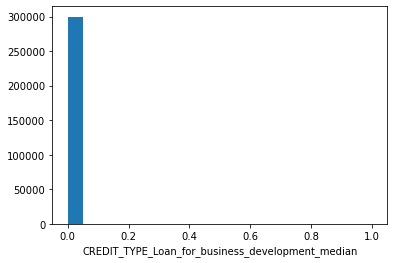

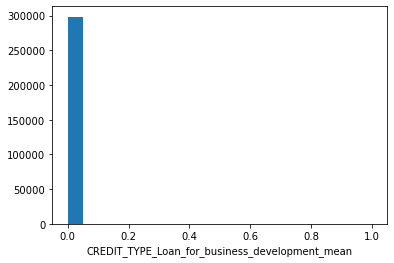

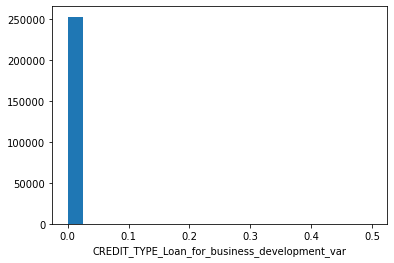

In [22]:
  
for col in datasets_agg['bureau_agg_data'].columns:
    plt.hist(datasets_agg['bureau_agg_data'][col], bins=20)
    plt.xlabel(col)
    plt.show()

In [14]:
# denormalize and clean text
for ds_name in datasets_agg:
    if ds_name == 'application_train':
        agg_data = datasets_agg['application_train'].replace(to_replace='\s+', value='_', regex=True) \
                                                    .replace(to_replace='\-', value='_', regex=True) \
                                                    .replace(to_replace='\/', value='_', regex=True) \
                                                    .replace(to_replace='\(', value='', regex=True) \
                                                    .replace(to_replace='\)', value='', regex=True) \
                                                    .replace(to_replace='\:', value='', regex=True) \
                                                    .replace(to_replace='\,', value='', regex=True)
    else:
        agg_data = agg_data.merge(datasets_agg[ds_name], on='SK_ID_CURR', how='left')


agg_data = agg_data.loc[:,~agg_data.columns.str.startswith('Unnamed:')]
agg_data = agg_data.loc[:,~agg_data.columns.str.startswith('SK_ID_PREV')]


### Train Test Split

In [15]:
# create train, validation, and test sets
y = agg_data['TARGET']
X = agg_data.drop(['SK_ID_CURR', 'TARGET', 'index'], axis = 1) #drop some features with questionable value


_, X, _, y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")

X train           shape: (39361, 1295)
X validation      shape: (9841, 1295)
X test            shape: (12301, 1295)


## Pipeline

### Collinear Feature Reduction

In [16]:
# determine feature types, reduce numerical features by collinearity reduction
id_col, feat_num, feat_cat, feature =  id_num_cat_feature(X, text = False)

cr = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),    
    CollinearityReducer(attribute_names=feat_num, threshold = 0.7, max_iter=2)
)

reduced_feat_num = cr.fit_transform(X_train[feat_num], y_train)

print(f'Reduced numerical column count from {len(feat_num)}...')
print(f'...to {len(reduced_feat_num)} by collinearity reduction.')

Reduced numerical column count from 1279...
...to 765 by collinearity reduction.


### Main Pipeline

In [ ]:
# Pipeline

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(reduced_feat_num)),
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

data_pipeline = ColumnTransformer(transformers=[
    ("num_pipeline", num_pipeline, feat_num),
    ("cat_pipeline", cat_pipeline, feat_cat)],
    remainder='drop',
    n_jobs=-1
)

full_pipeline_with_predictor = Pipeline([
    ("preparation", data_pipeline),
    ('pca', PCA()),
    ("logistic_Reg", LogisticRegression(solver="liblinear"))
])

n_components = [10,50,100,500]
C = np.logspace(-3,4,8)  #(E-3 to E+4)
penalty = [None,'l1','l2']

parameters = dict(
    pca__n_components = n_components,
    logistic_Reg__C = C,
    logistic_Reg__penalty = penalty
)

grid = GridSearchCV(
    full_pipeline_with_predictor, param_grid= parameters, 
    cv = 5, n_jobs=-1, scoring='roc_auc', verbose=2
)

grid.fit(X_train, y_train)

### Scoring

In [21]:
grid.best_params_

{'logistic_Reg__penalty': 'l1'}

In [22]:
# get results of pipeline from validation and test sets for accuracy and AUC-ROC
X_valid.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train AUC", 
                                   "Valid AUC",
                                   "Test  AUC"
                                  ])

exp_name = f"agg_1293_collinreduce:0.7-2_{grid.best_params_}"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, grid.predict(X_train)), 
                accuracy_score(y_valid, grid.predict(X_valid)),
                accuracy_score(y_test, grid.predict(X_test)),
                roc_auc_score(y_train, grid.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, grid.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,agg_1293_collinreduce_0.7_2,0.9225,0.9175,0.9182,0.7972,0.7507,0.7543
1,agg_1293_collinreduce:0.7-2_reg-L1,0.9223,0.9175,0.9184,0.7962,0.7532,0.7558
